In [1]:
!pip install xgboost==0.90
!pip install catboost==0.18.1
!pip install shap

   ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.3 MB 660.6 kB/s eta 0:00:28
   ---------------------------------------- 0.1/18.3 MB 1.1 MB/s eta 0:00:18
    --------------------------------------- 0.3/18.3 MB 1.9 MB/s eta 0:00:10
   - -------------------------------------- 0.8/18.3 MB 3.8 MB/s eta 0:00:05
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/18.3 MB 4.7 MB/s eta 0:00:04
   -- -----


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\URIST\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip
ERROR: Ignored the following yanked versions: 0.1.1
ERROR: Could not find a version that satisfies the requirement catboost==0.18.1 (from versions: 1.2, 1.2.1, 1.2.1.1, 1.2.2, 1.2.3, 1.2.5)
ERROR: No matching distribution found for catboost==0.18.1

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\URIST\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\URIST\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   --- ----------------------------------- 41.0/456.1 kB 991.0 kB/s eta 0:00:01
   -------------- ------------------------- 163.8/456.1 kB 2.0 MB/s eta 0:00:01
   ---------------------------------- ----- 389.1/456.1 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 15.9 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.7 MB 17.3 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 20.4 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 17.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -- ------------------------------------- 1.6/28.1 MB 52.5 MB/s eta 0:00:01
   ----- ---------------------------------- 3.6/28.1 MB 38.4 MB/s eta 0:00:01
   ---

In [2]:
import os
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

shap.initjs()

## Градиетный бустинг "на пальцах"

In [2]:
x = np.arange(0, 50)
x = pd.DataFrame({"x": x})

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

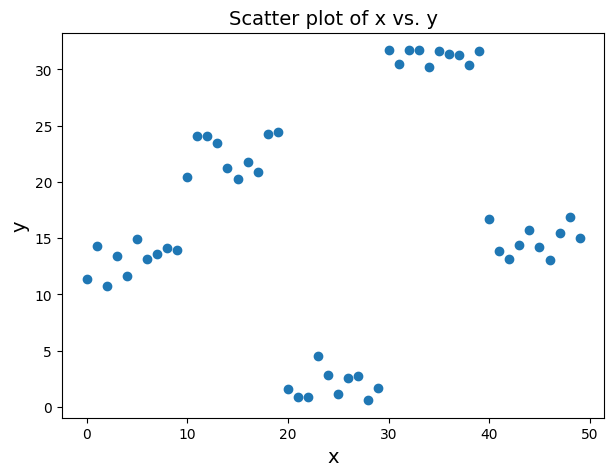

In [3]:
plt.figure(figsize=(7,5))
plt.plot(x, y, "o")
plt.title("Scatter plot of x vs. y", size=14)
plt.xlabel("x", size=14)
plt.ylabel("y", size=14)

plt.show()

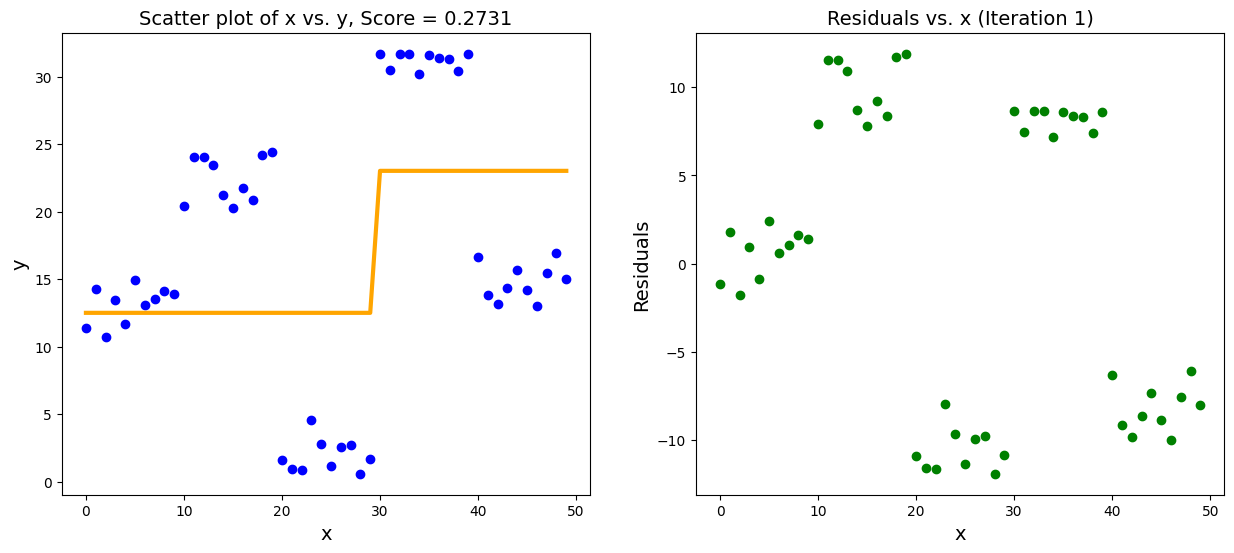

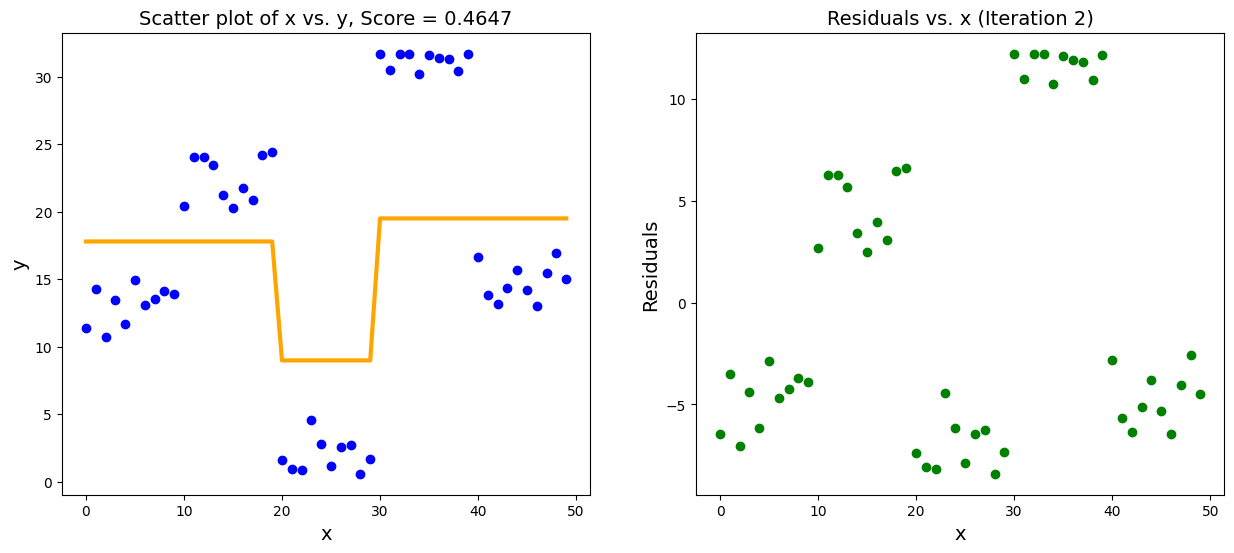

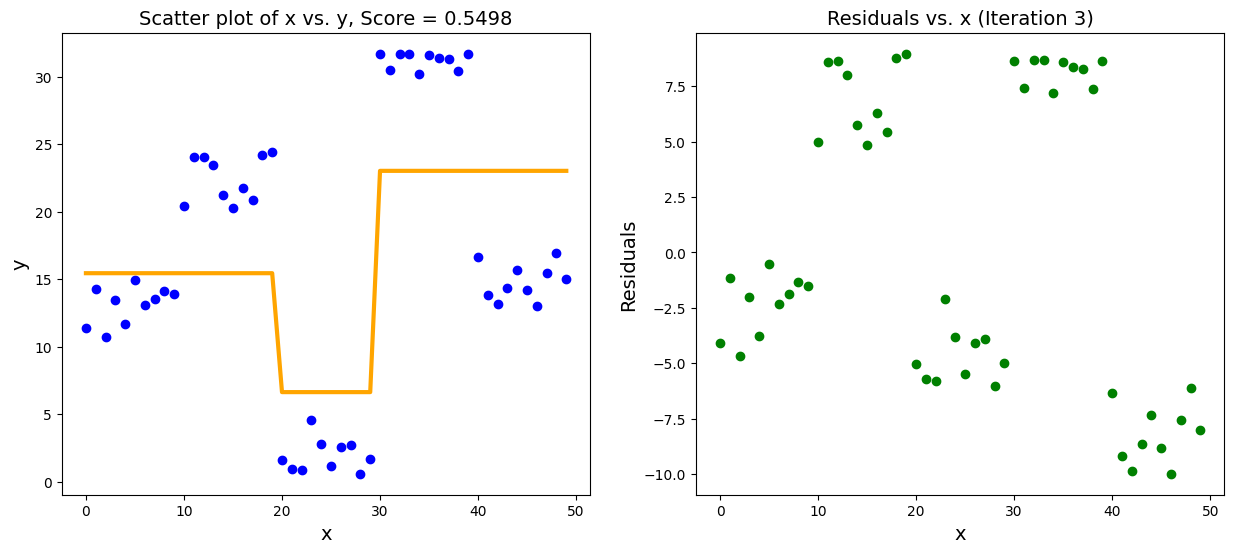

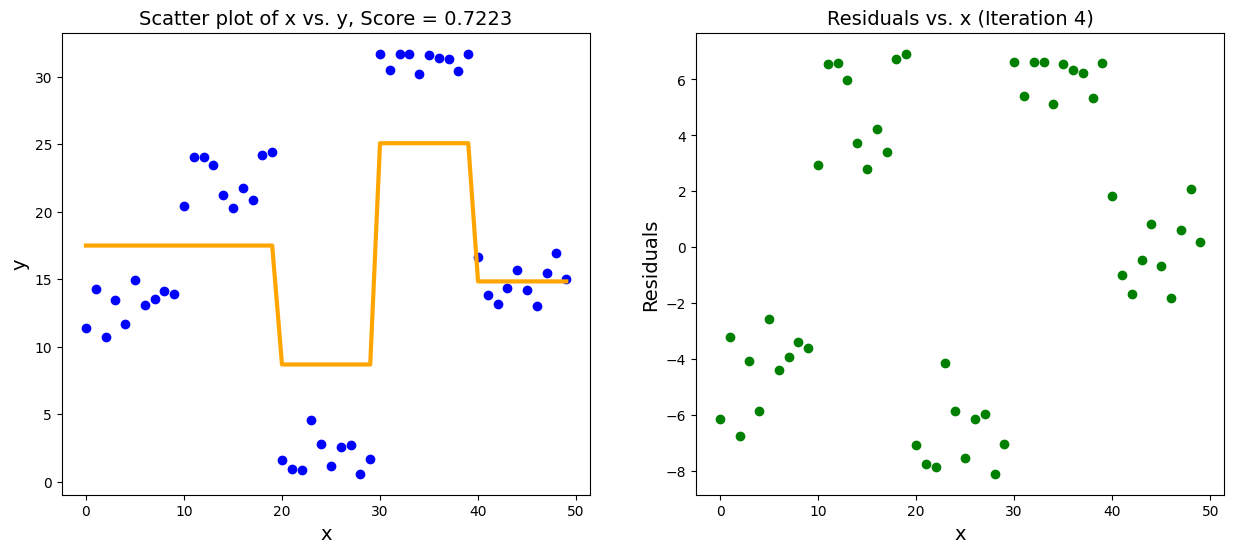

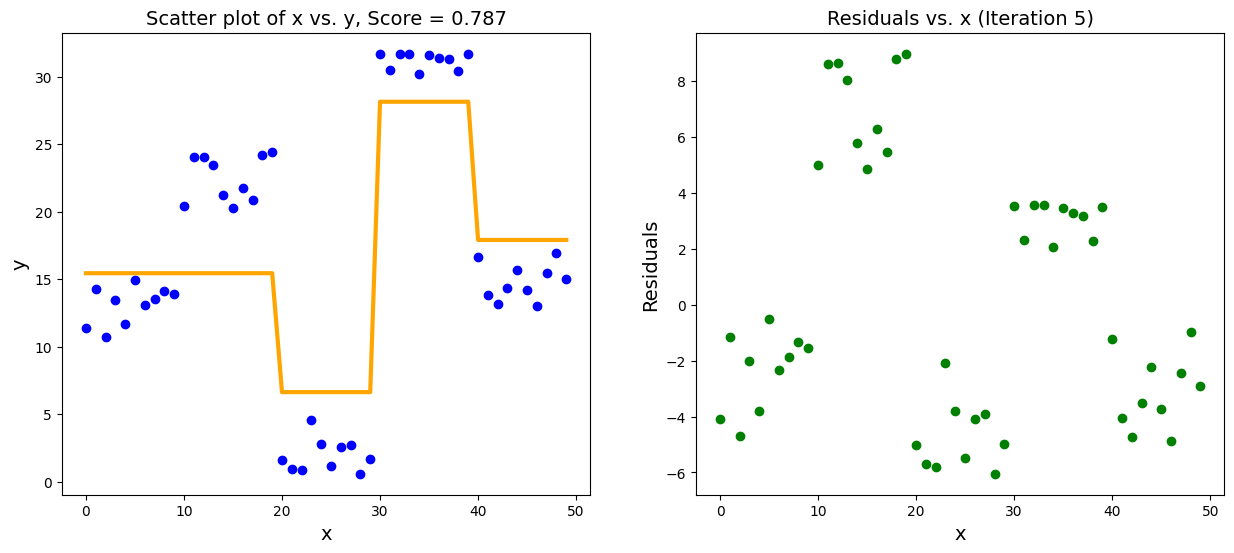

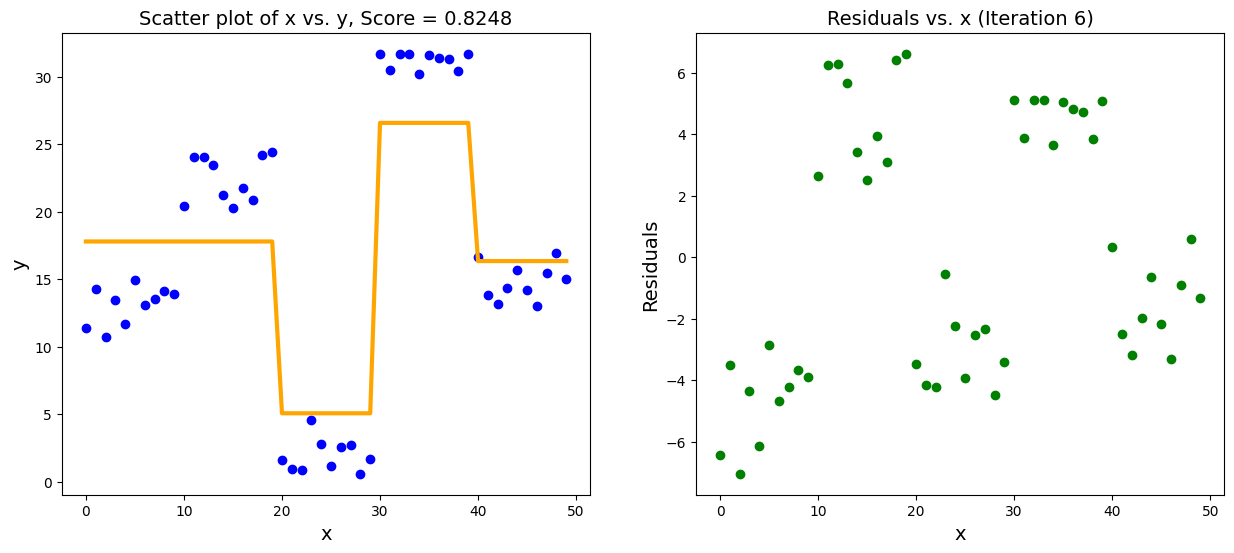

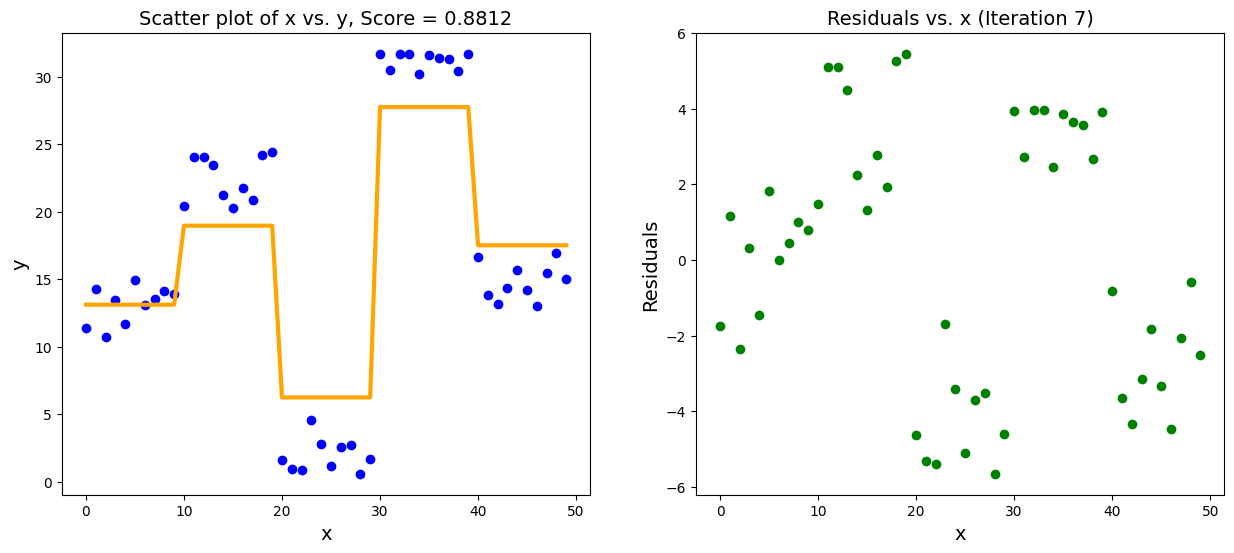

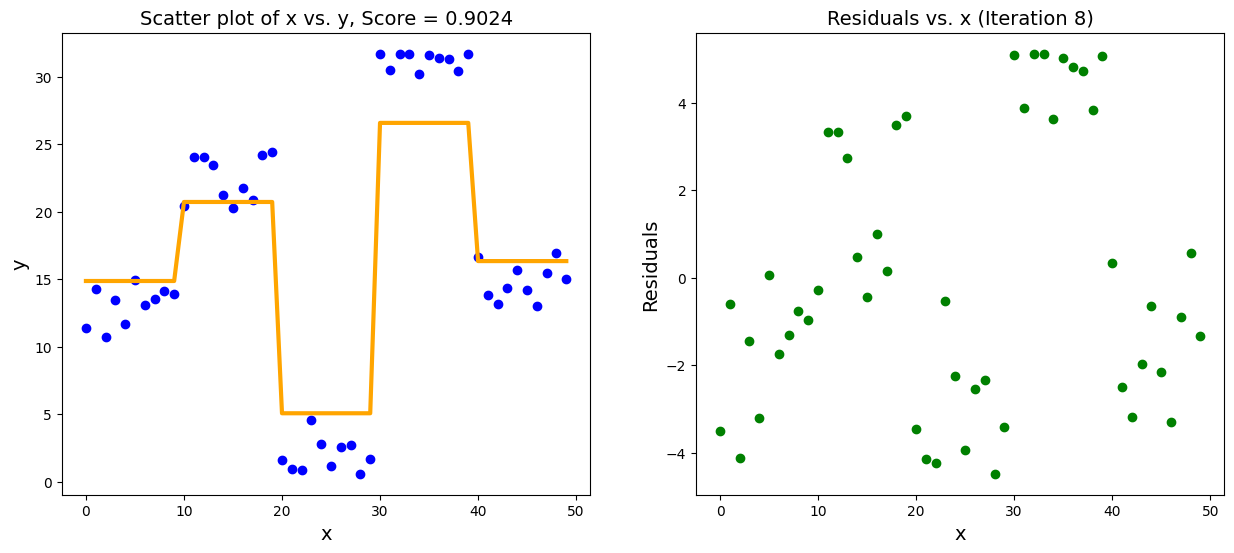

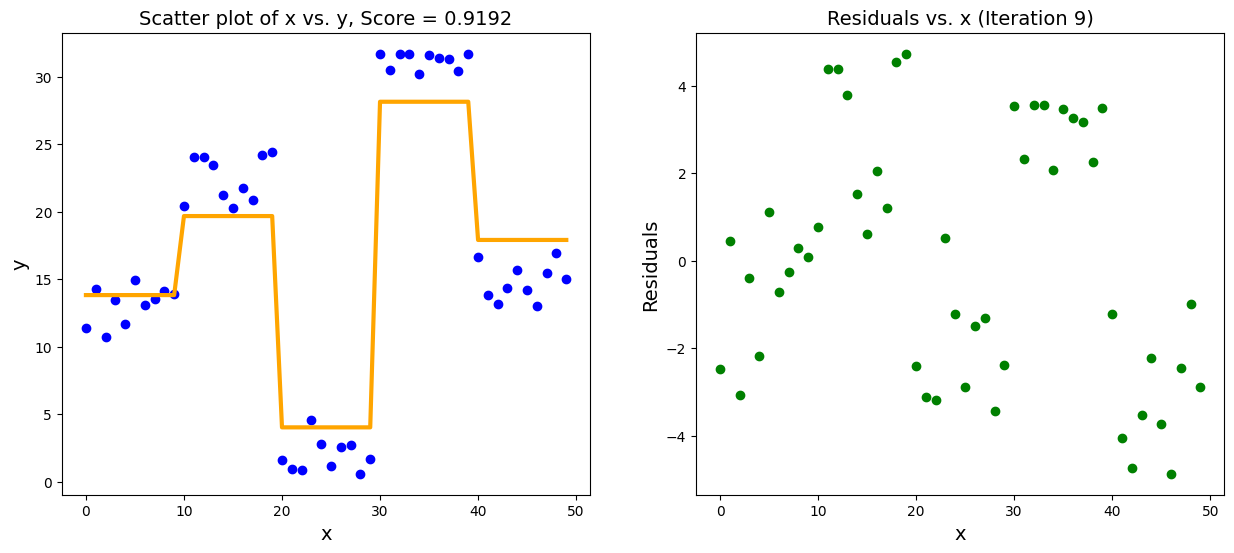

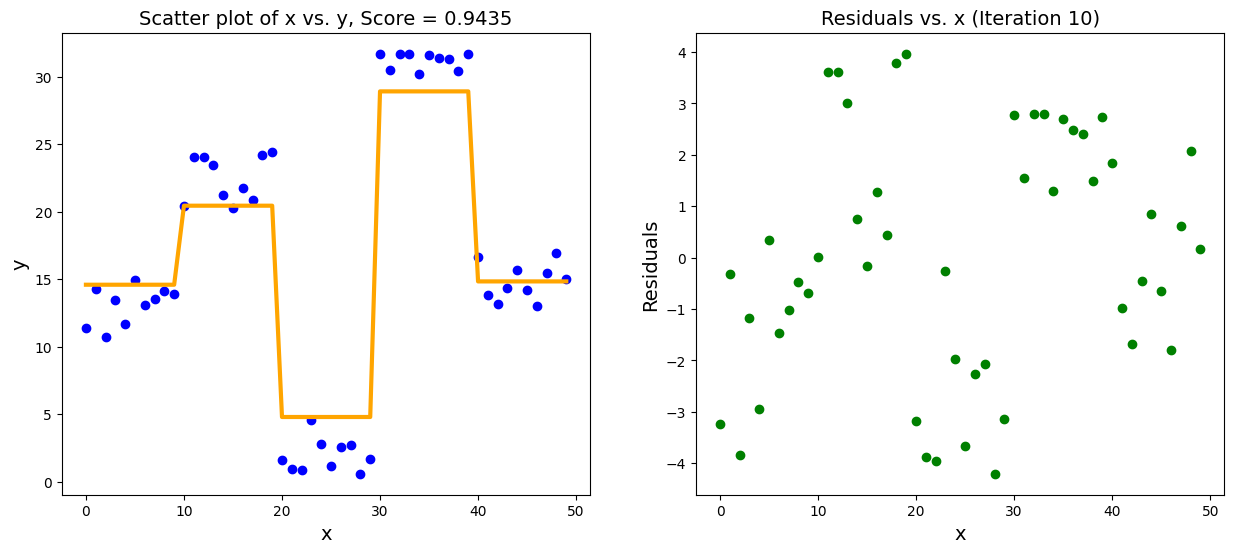

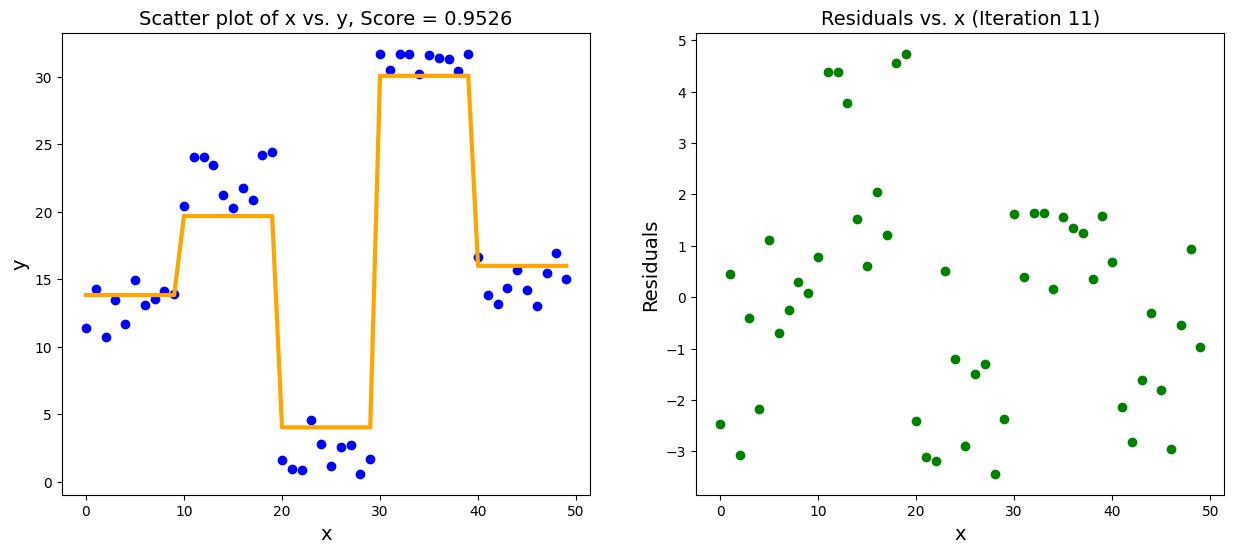

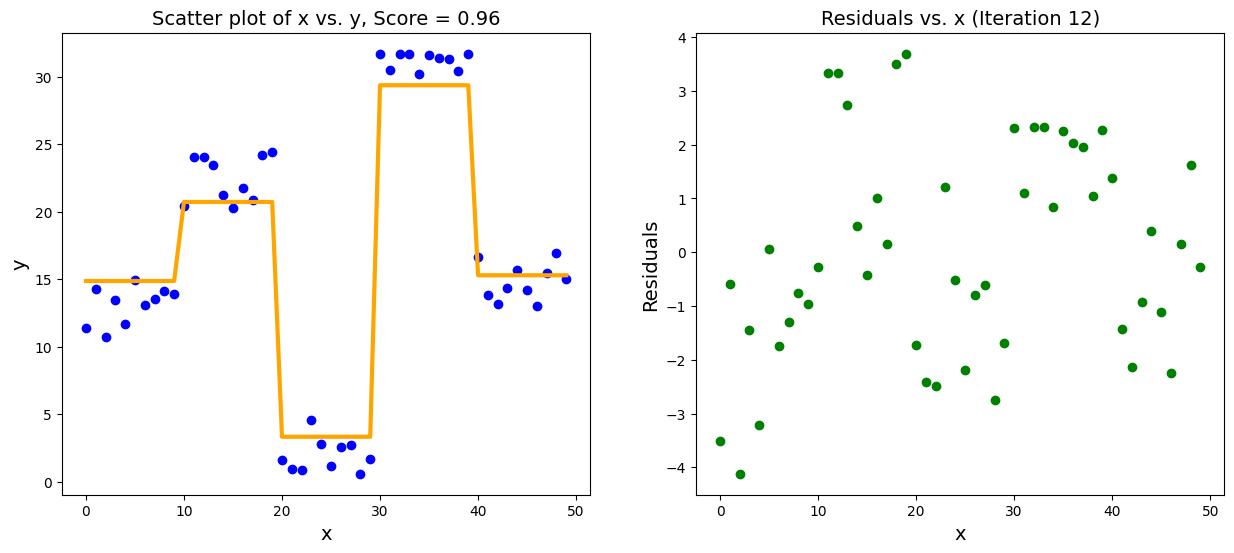

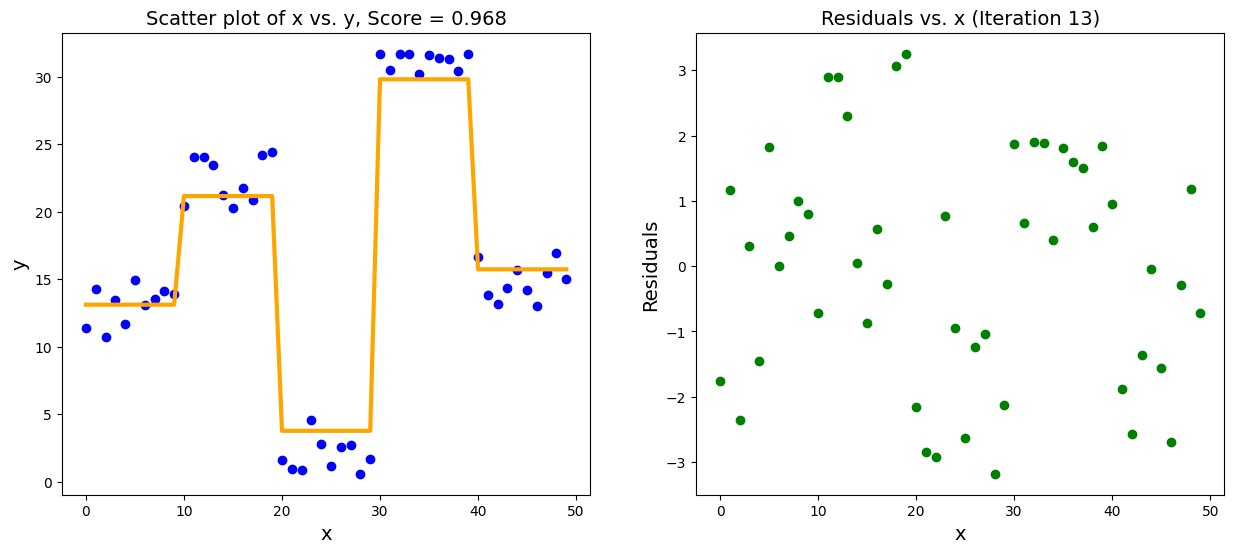

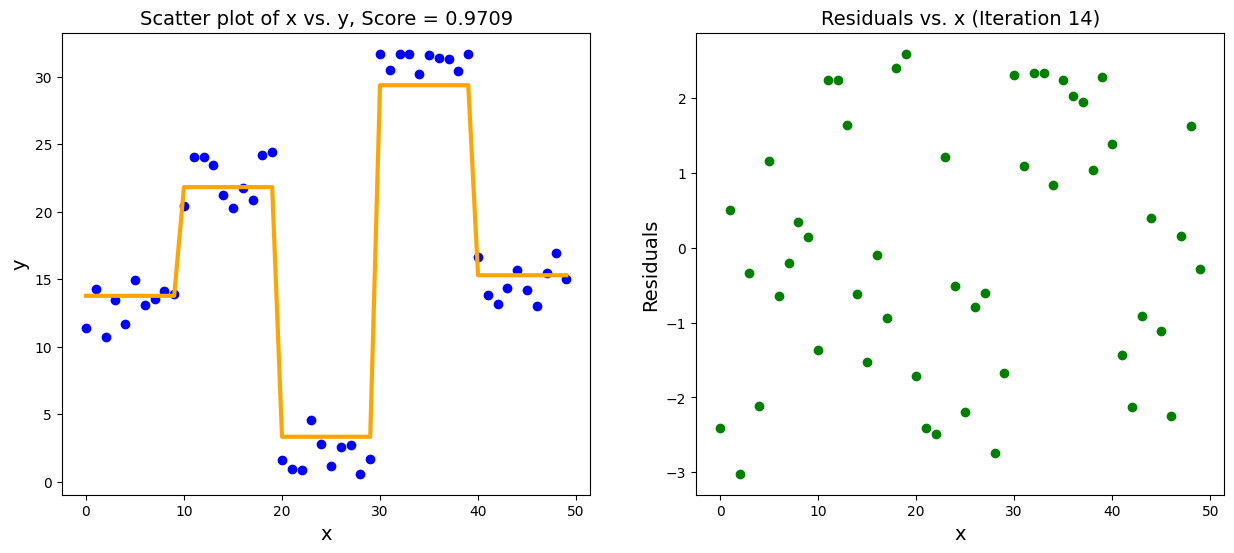

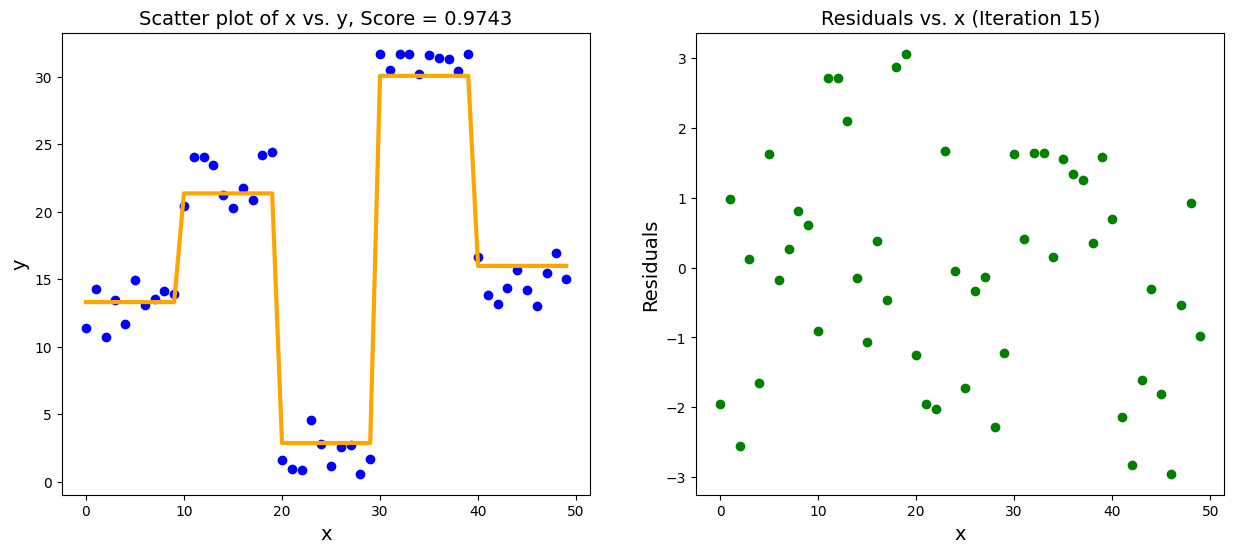

In [4]:
trees = []
y_ = y.copy()

for i in range(15):

    tree = DecisionTreeRegressor(max_depth=1, random_state=27)
    tree.fit(x, y_)

    trees.append(tree)
    y_pred = 0

    for tree in trees:
        y_pred += tree.predict(x).reshape((50, 1))

    # общее отклонение от таргета на данной итерации предсказаний
    residuals = y - y_pred

    # на следующей итерации будем предсказывать лишь остатки от предсказания предыдущих остатков и т.д.
    y_ = y_ - tree.predict(x).reshape((50, 1))
    
    score = r2_score(
        y, y_pred
    )

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(x, y, "o", color="blue")
    plt.plot(x, y_pred, color="orange", linewidth=3)
    plt.title(f"Scatter plot of x vs. y, Score = {round(score, 4)}", size=14)
    plt.xlabel("x", size=14)
    plt.ylabel("y", size=14)

    plt.subplot(122)
    plt.plot(x, residuals, "o", color="green")
    plt.title(f"Residuals vs. x (Iteration {i+1})", size=14)
    plt.ylabel("Residuals", size=14)
    plt.xlabel("x", size=14)
    plt.show()

## А как работает бэггинг?

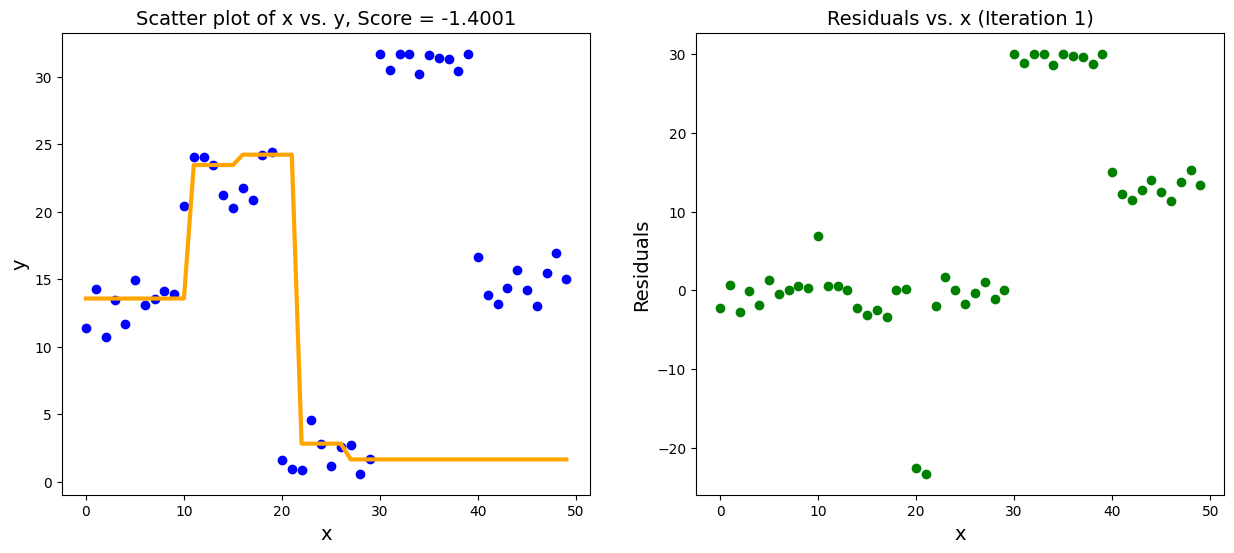

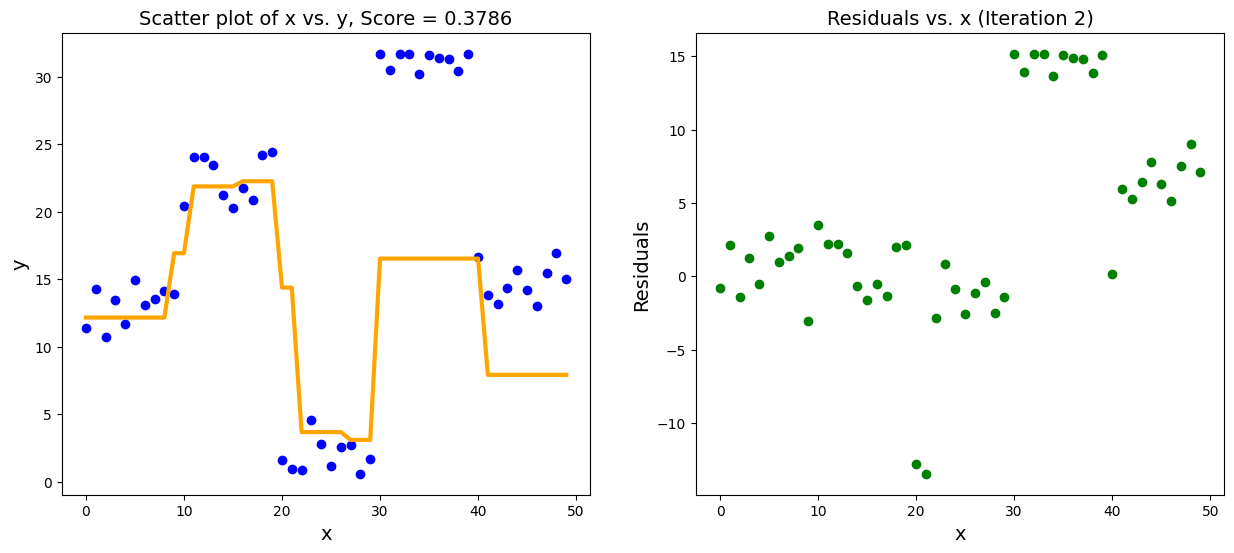

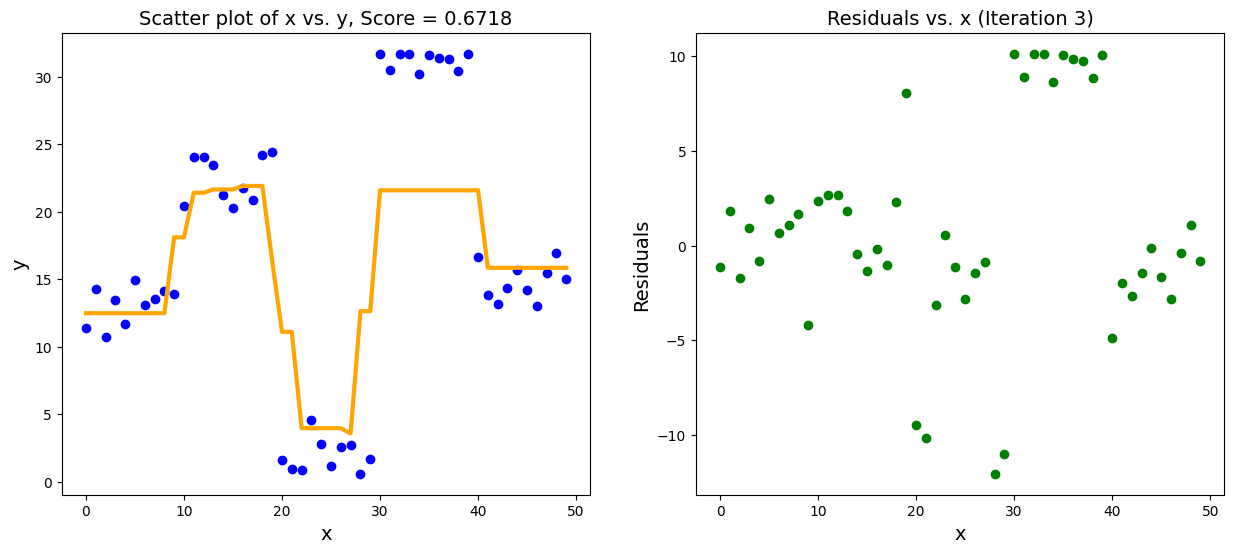

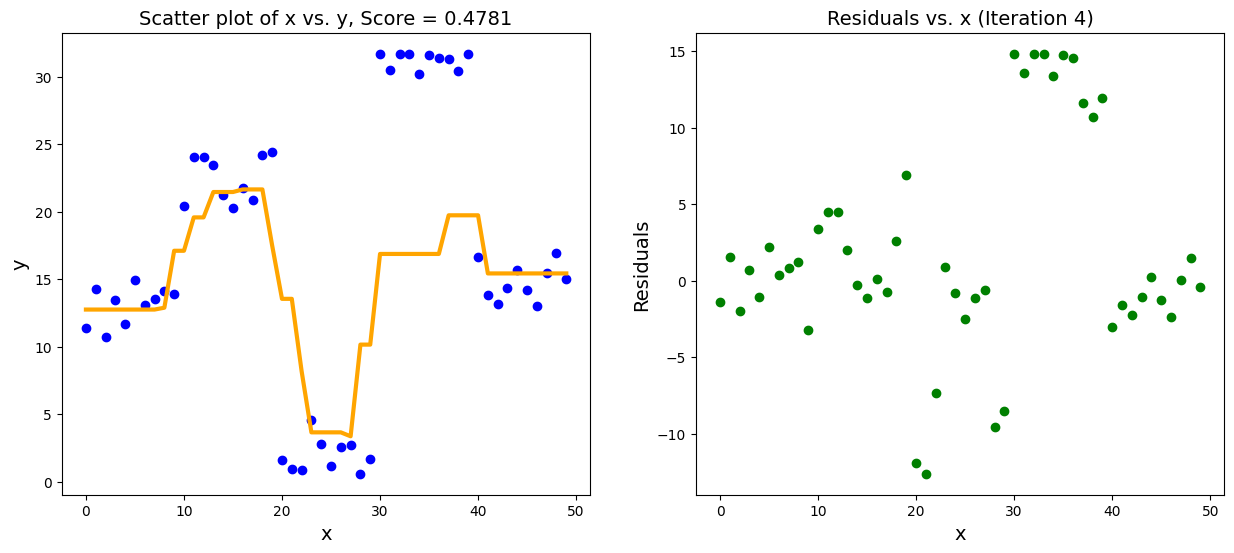

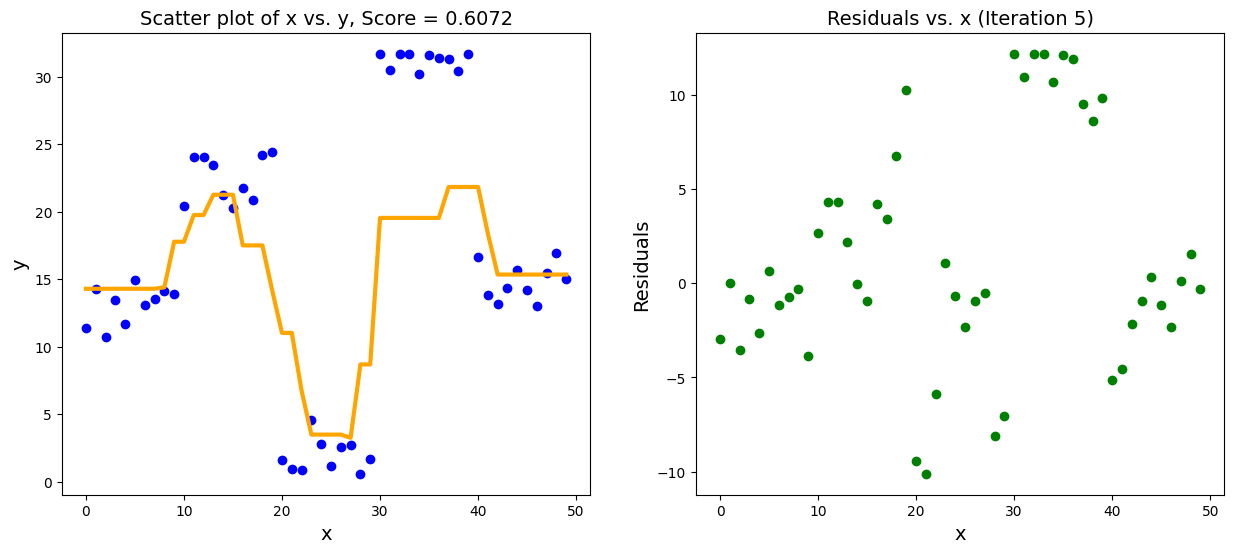

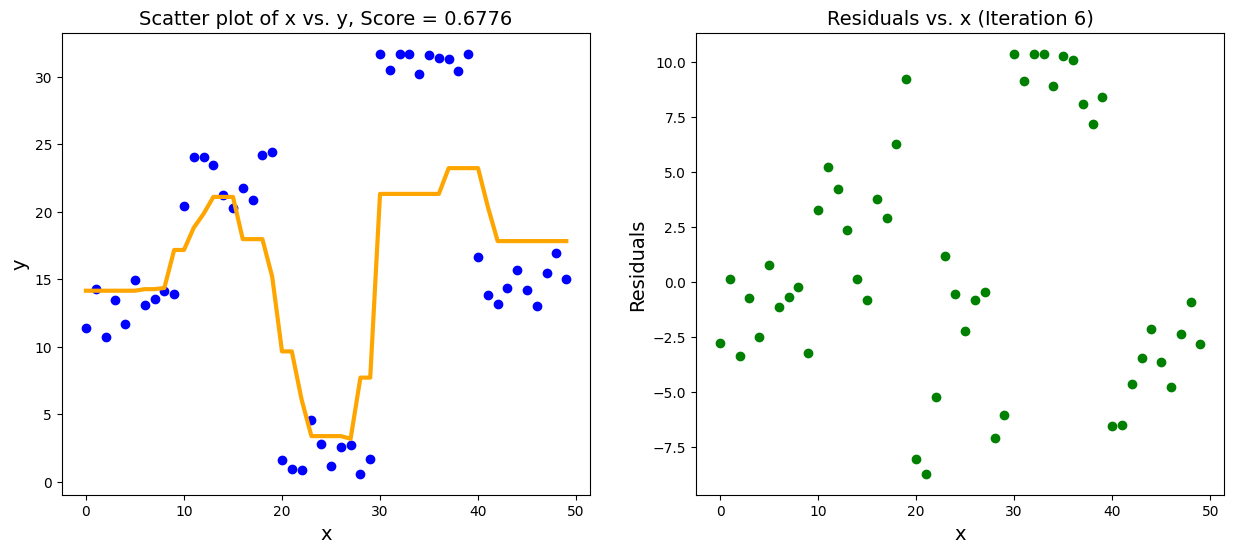

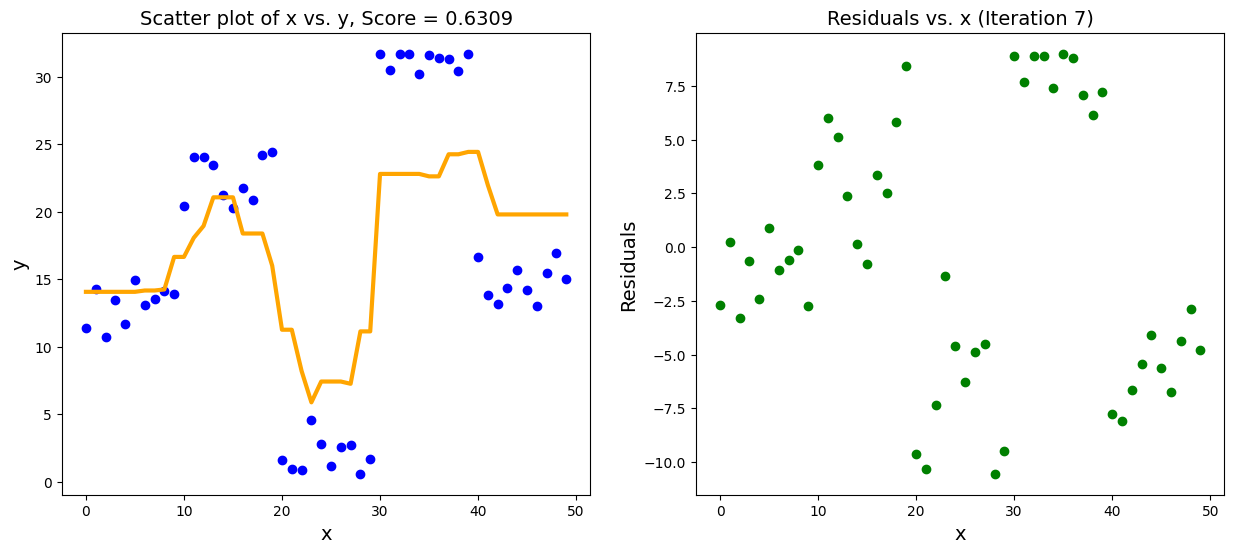

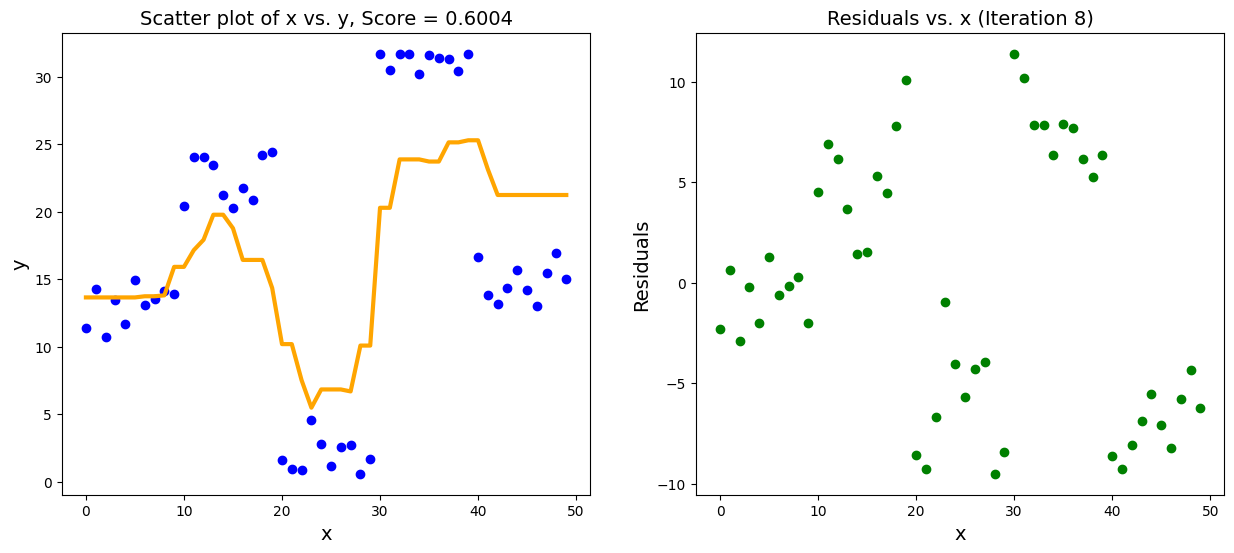

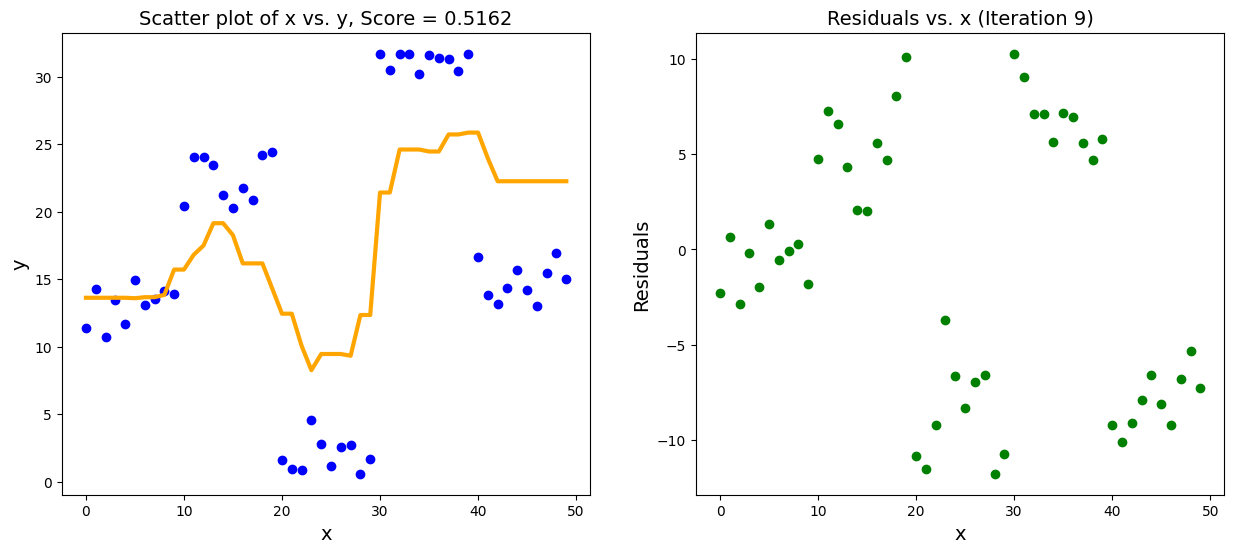

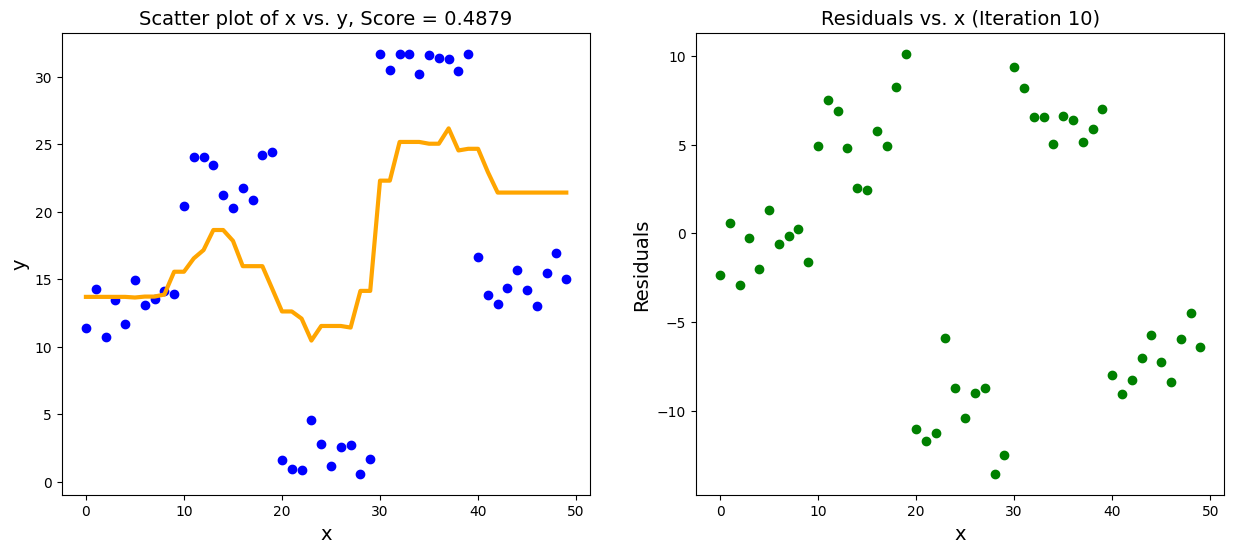

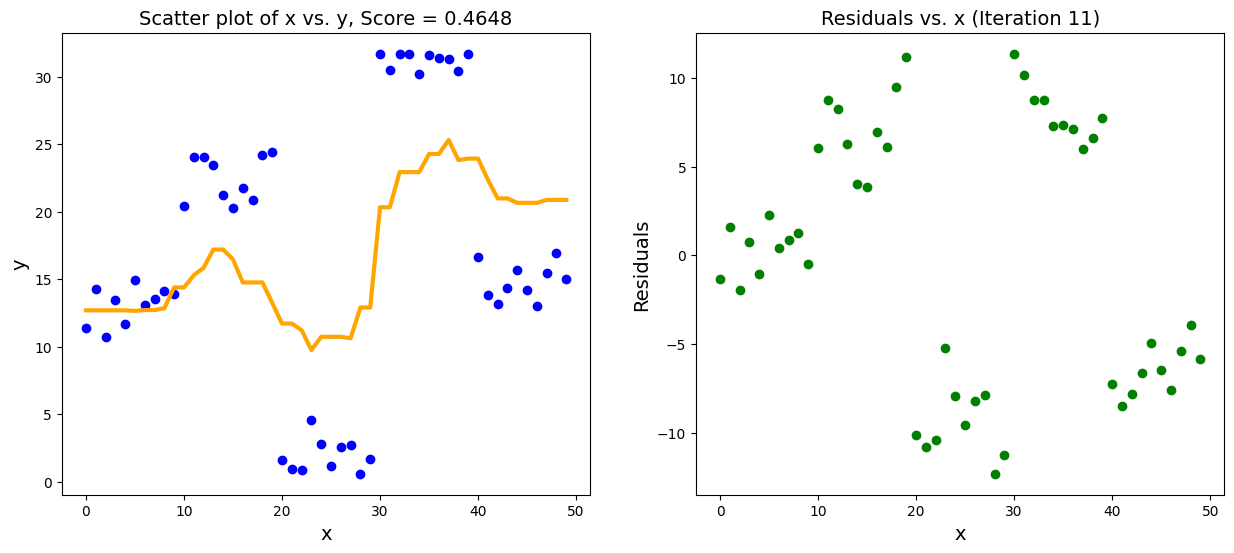

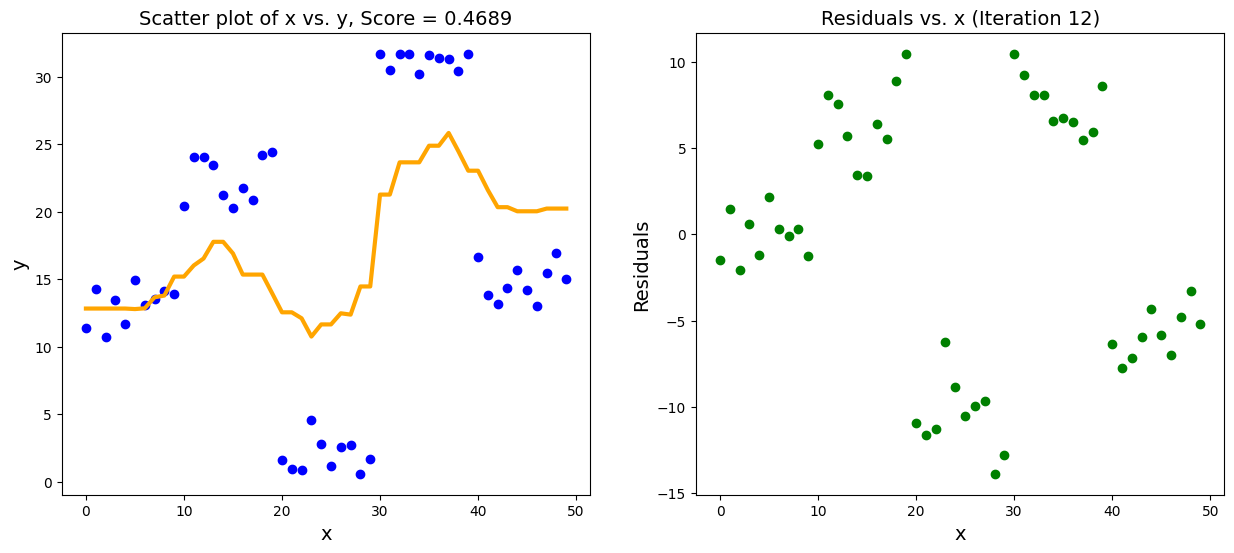

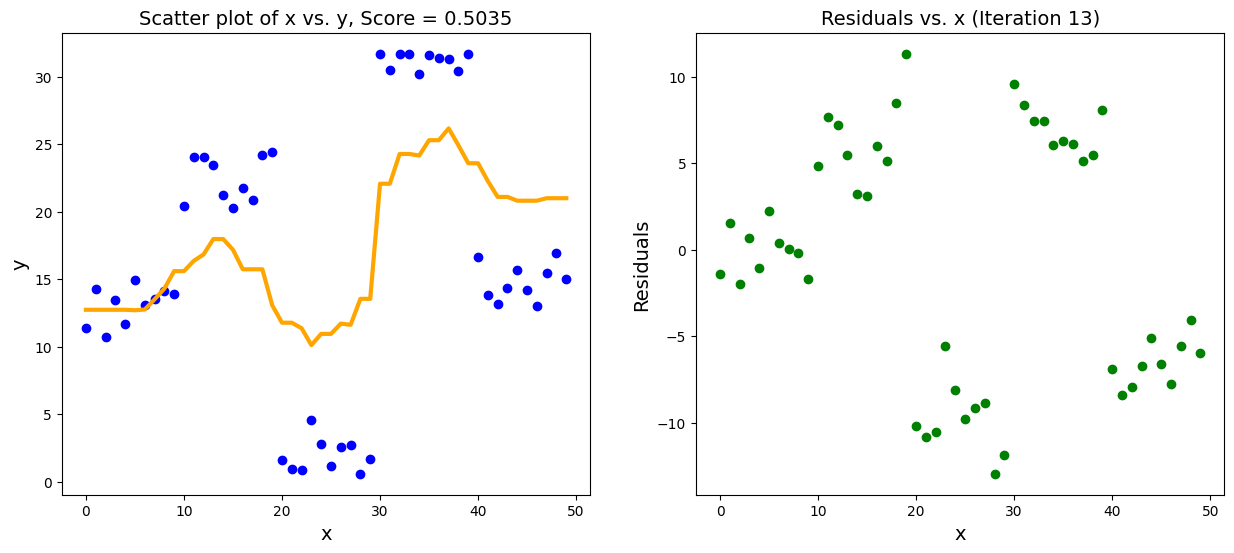

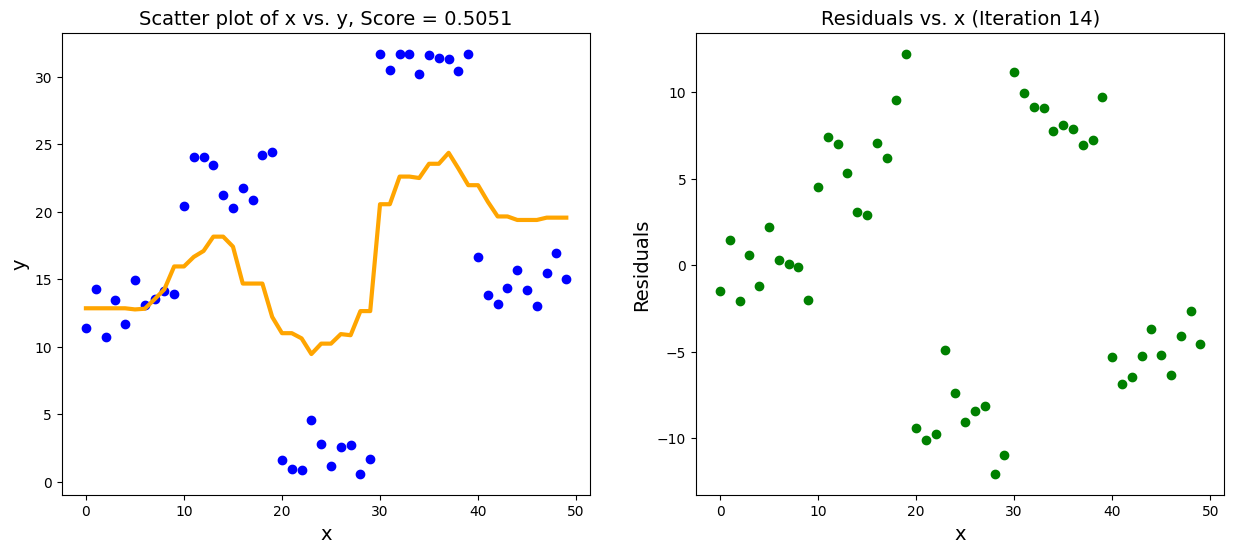

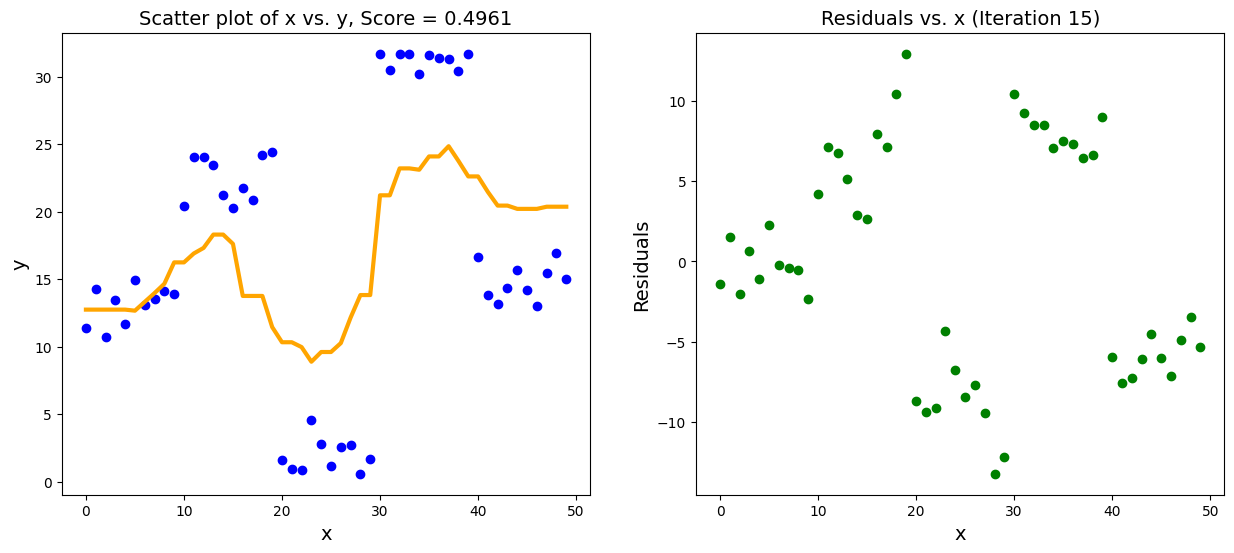

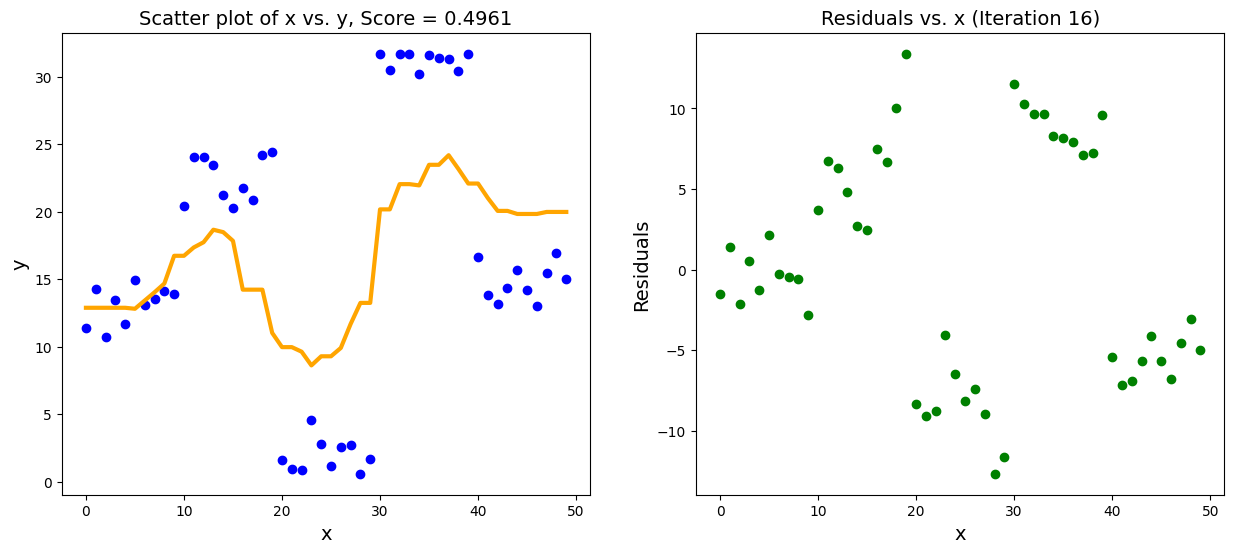

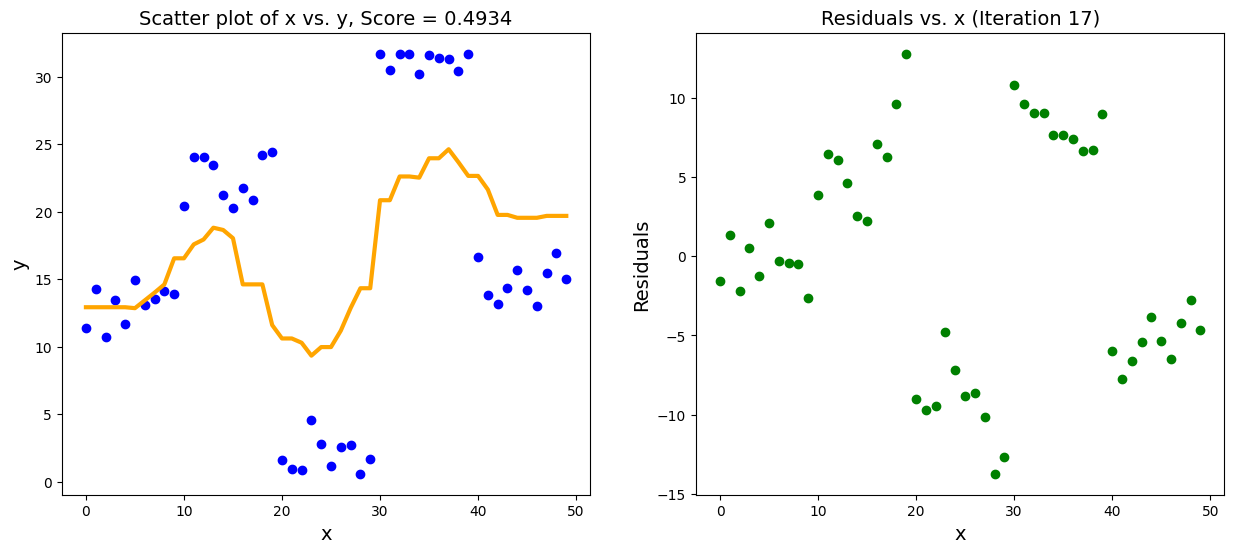

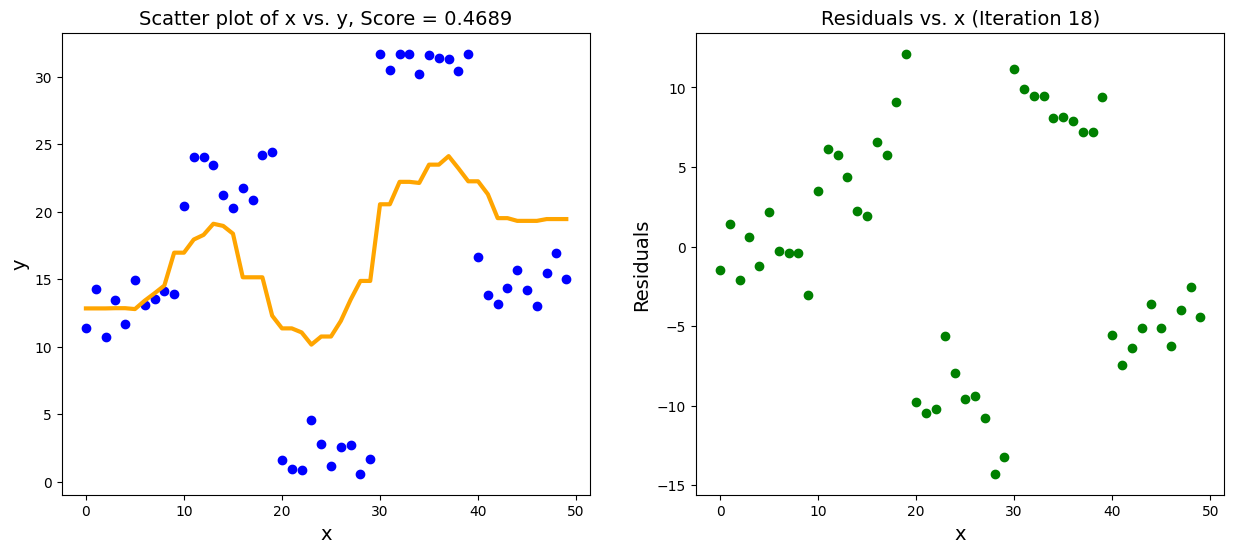

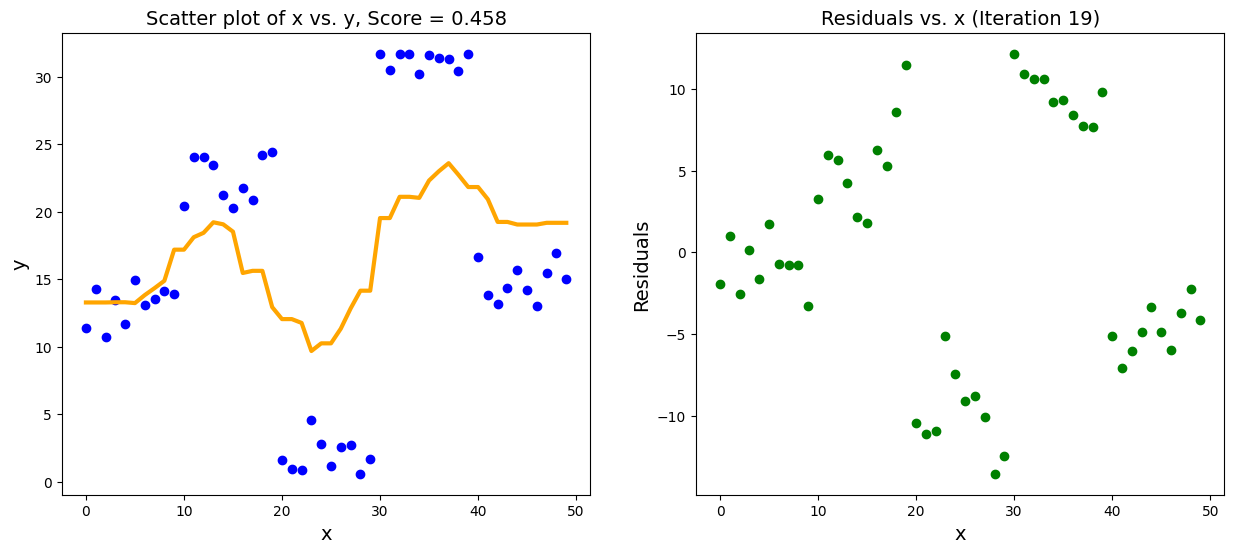

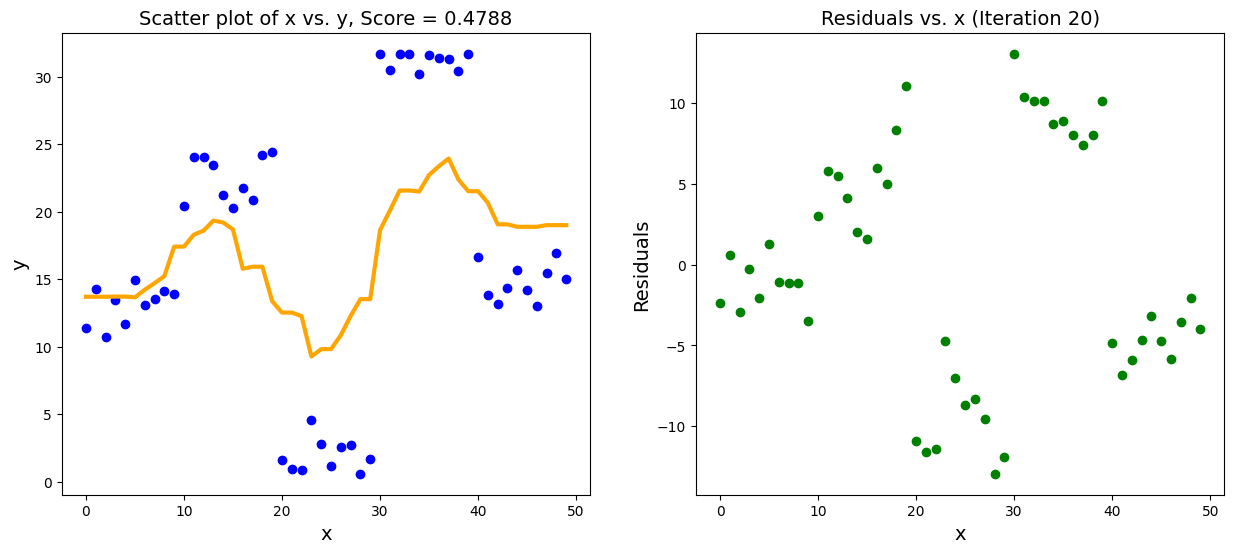

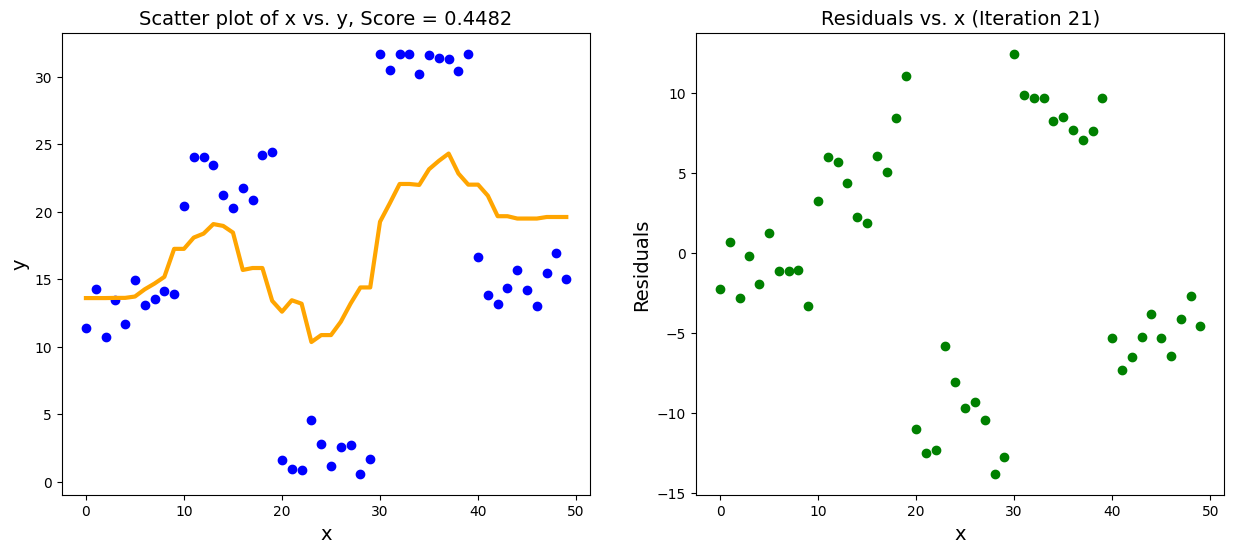

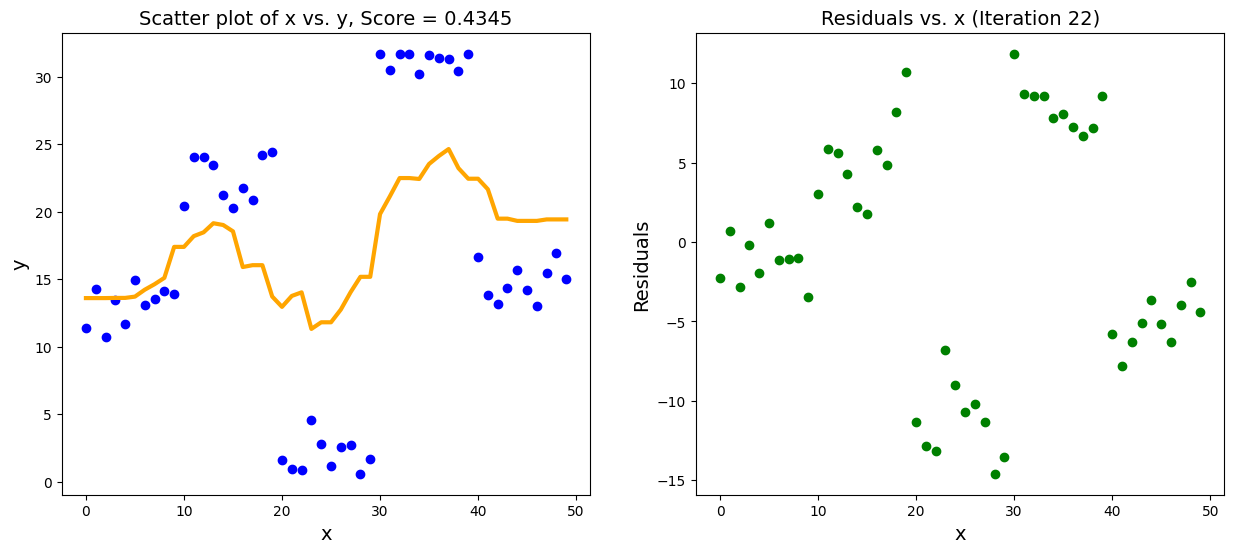

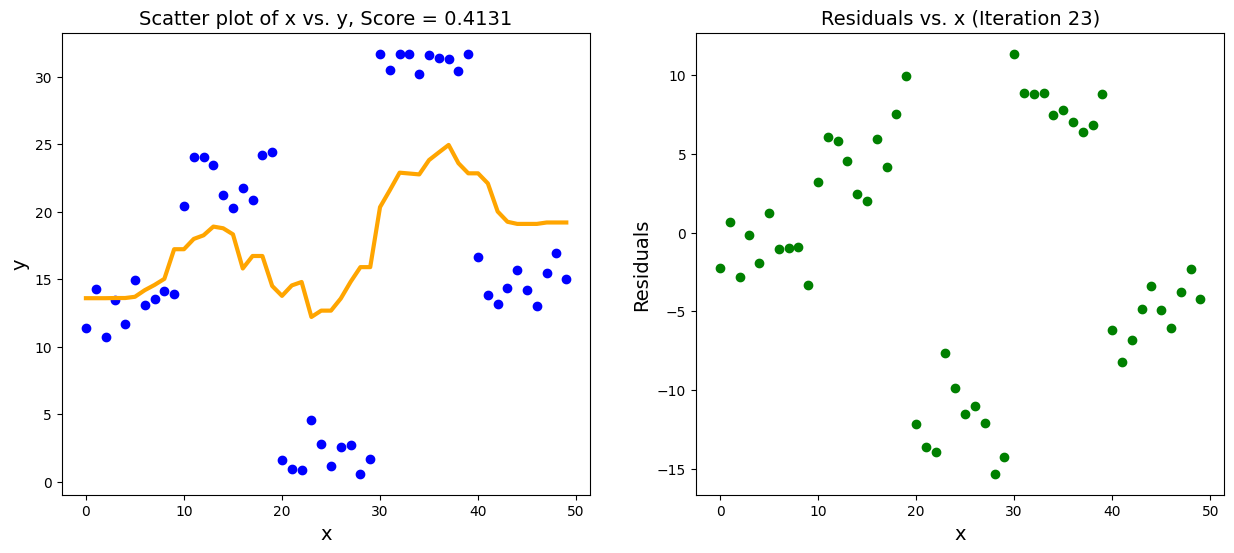

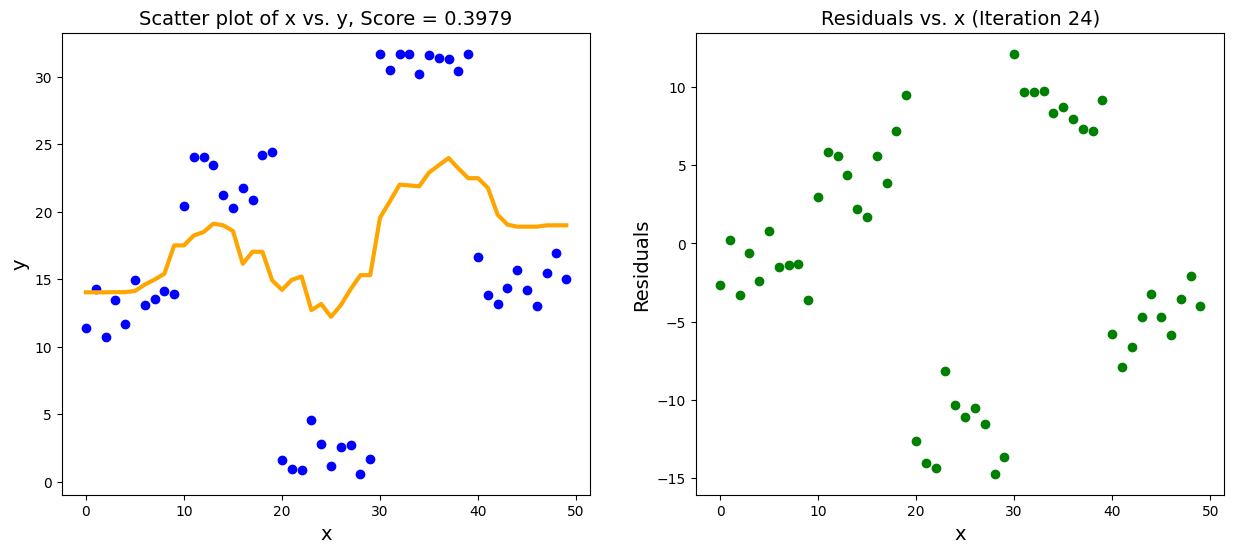

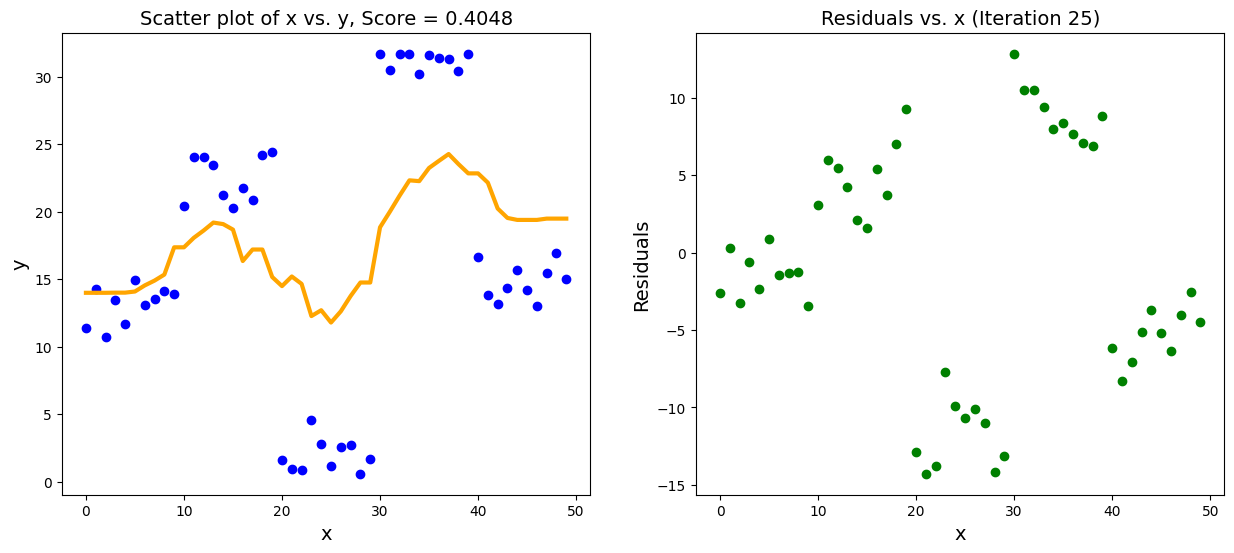

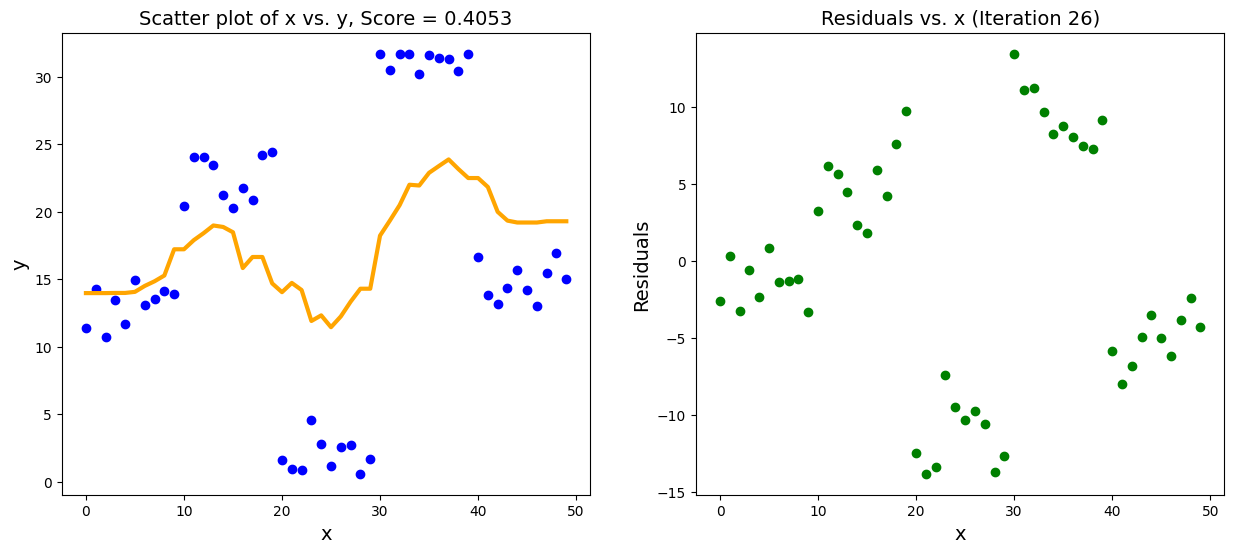

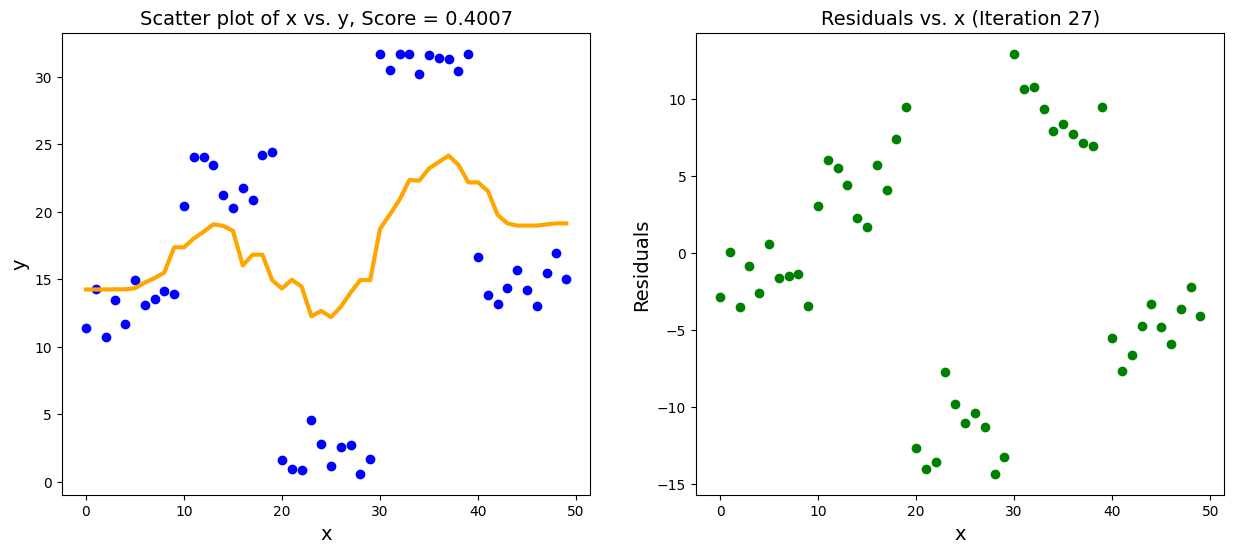

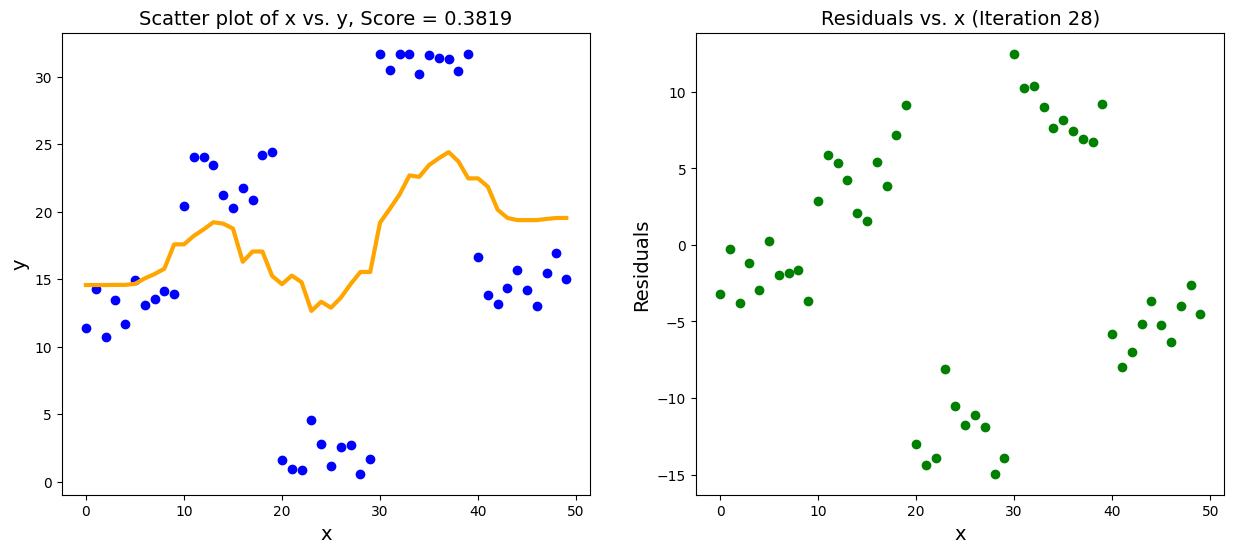

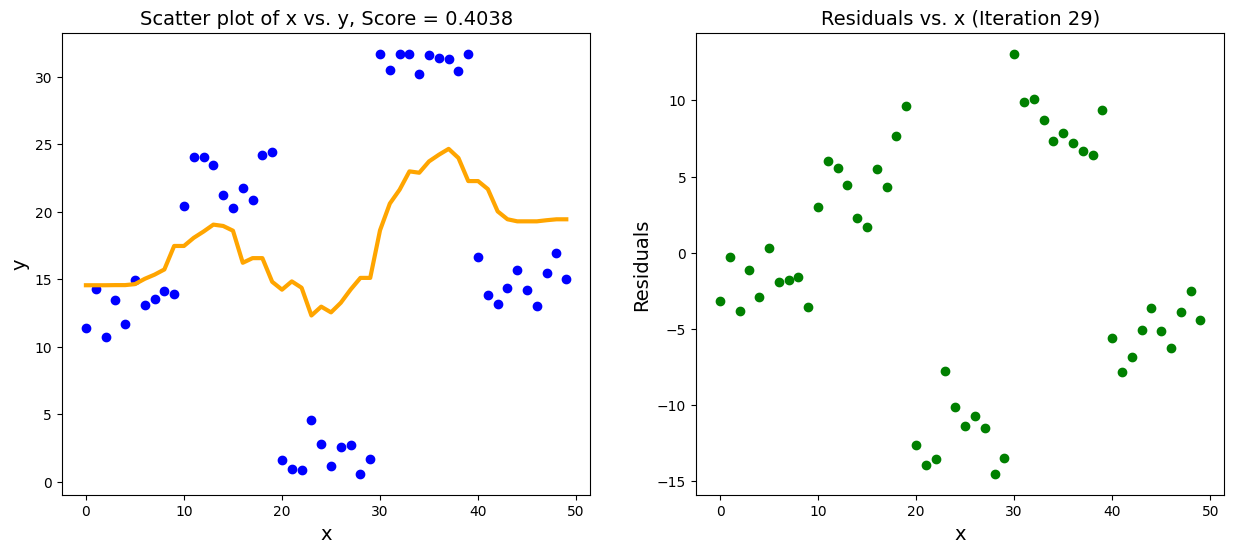

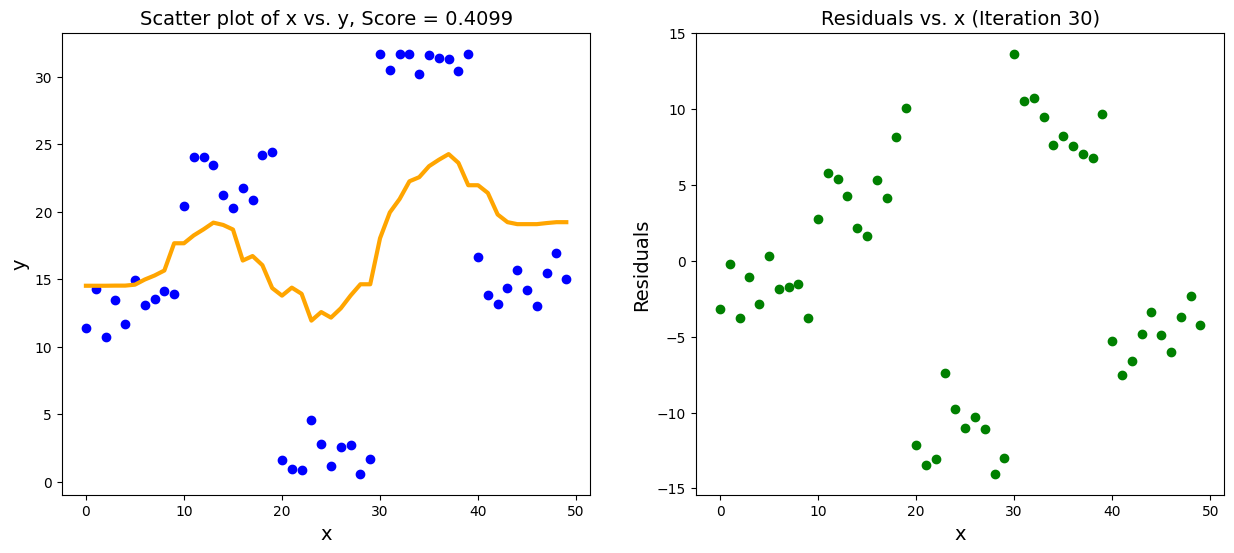

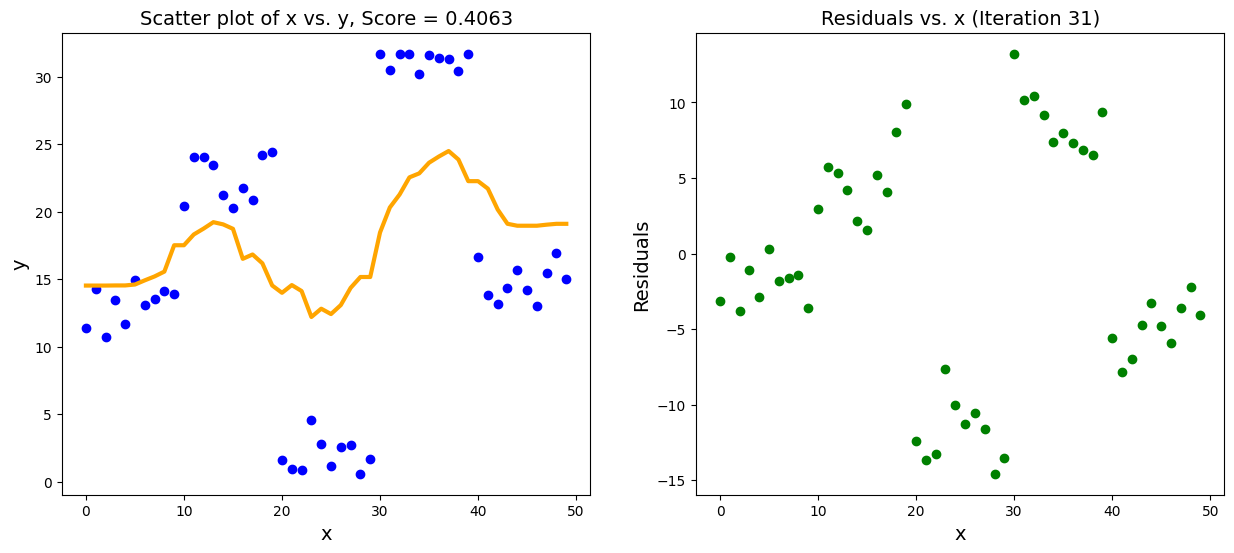

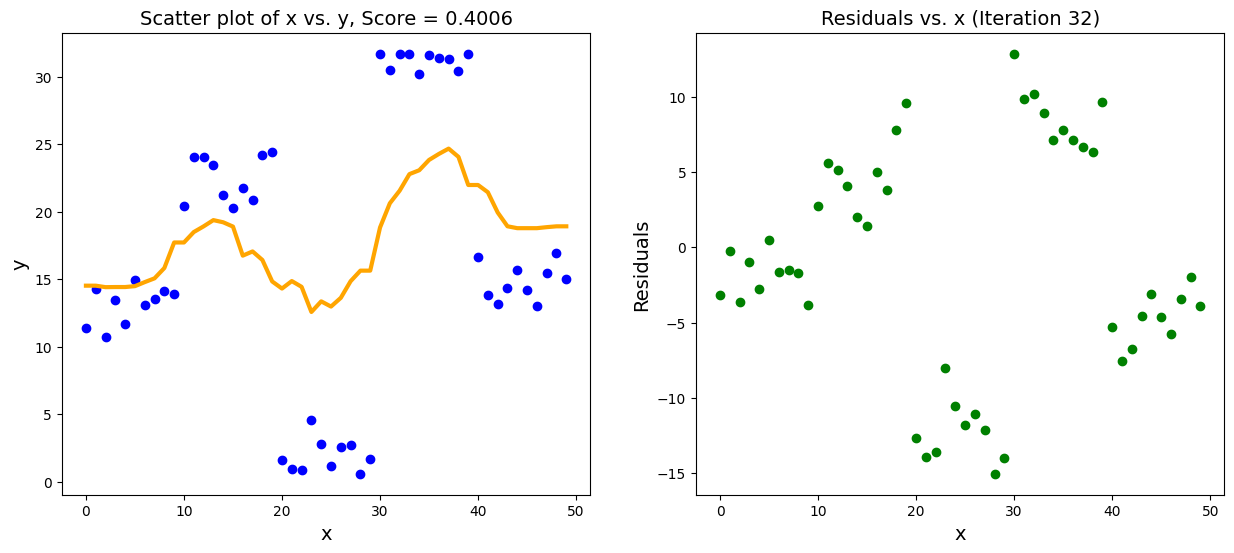

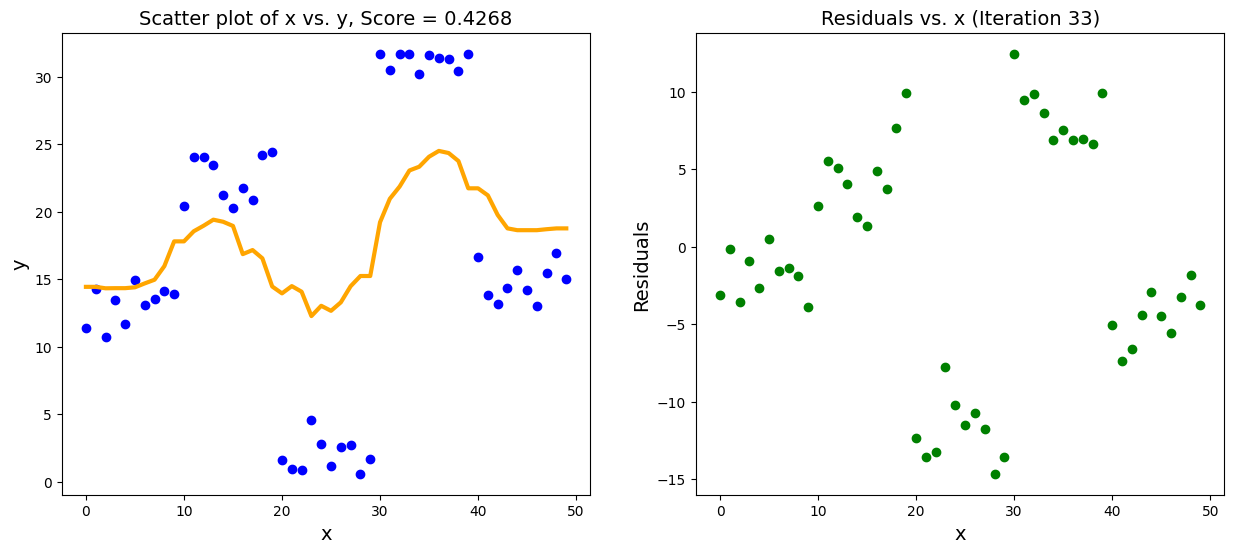

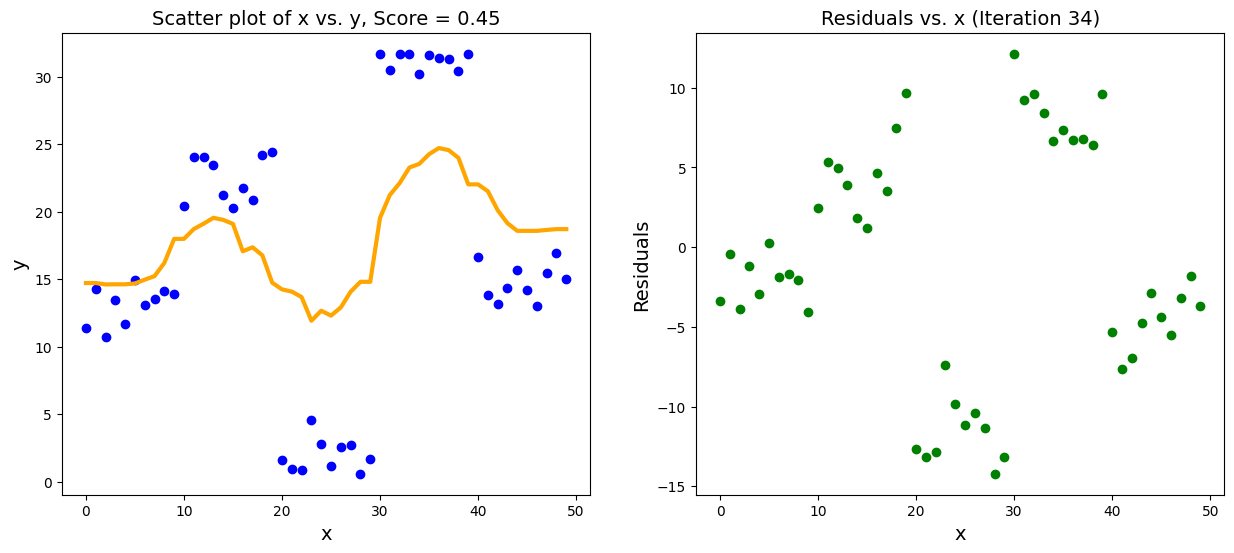

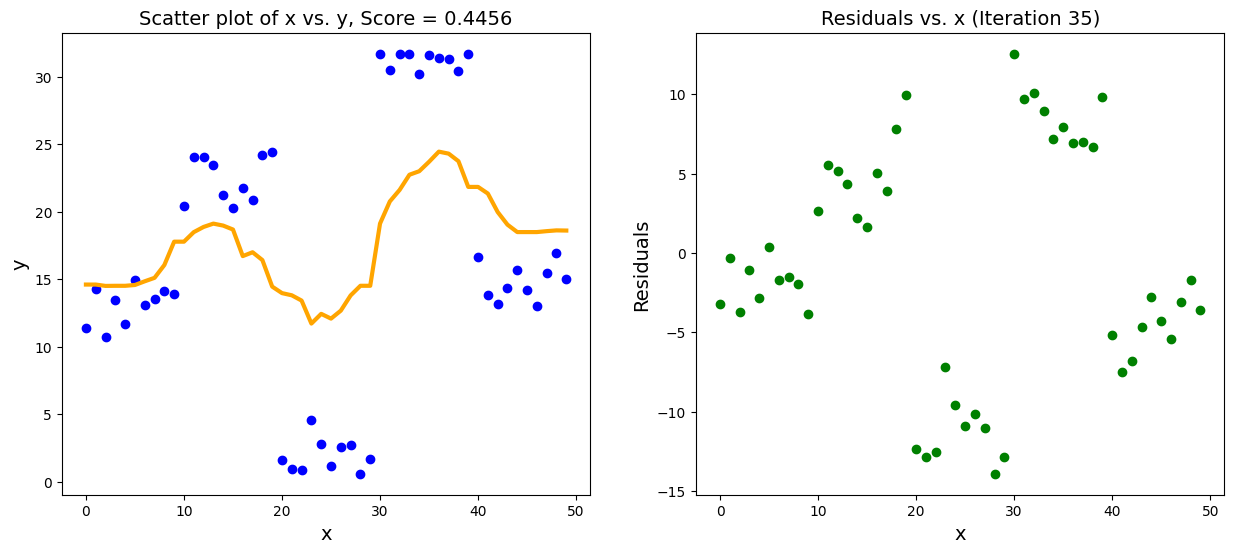

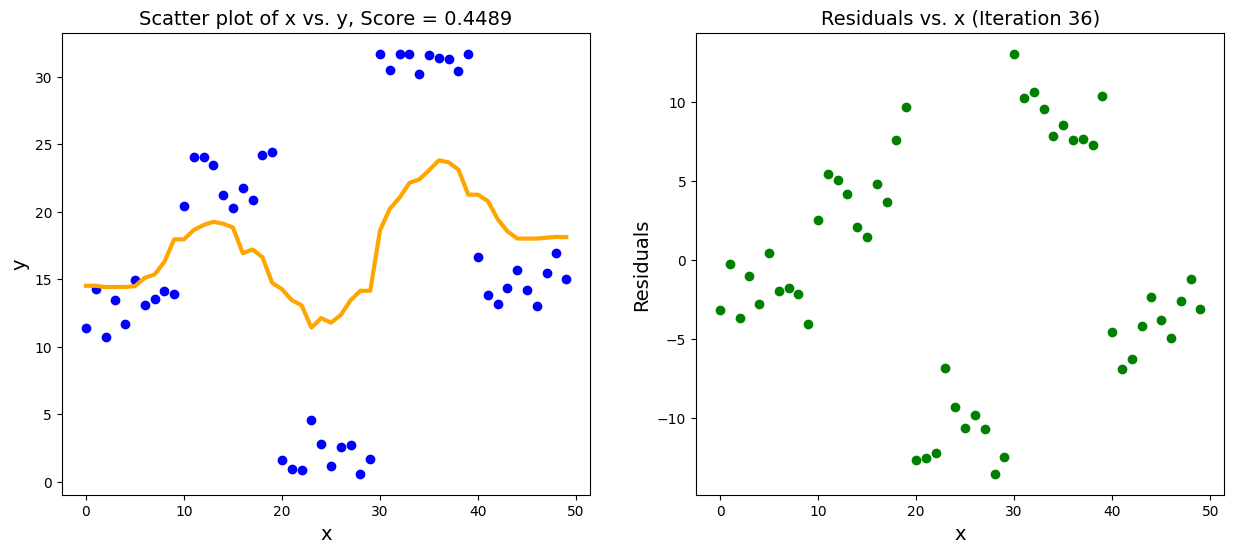

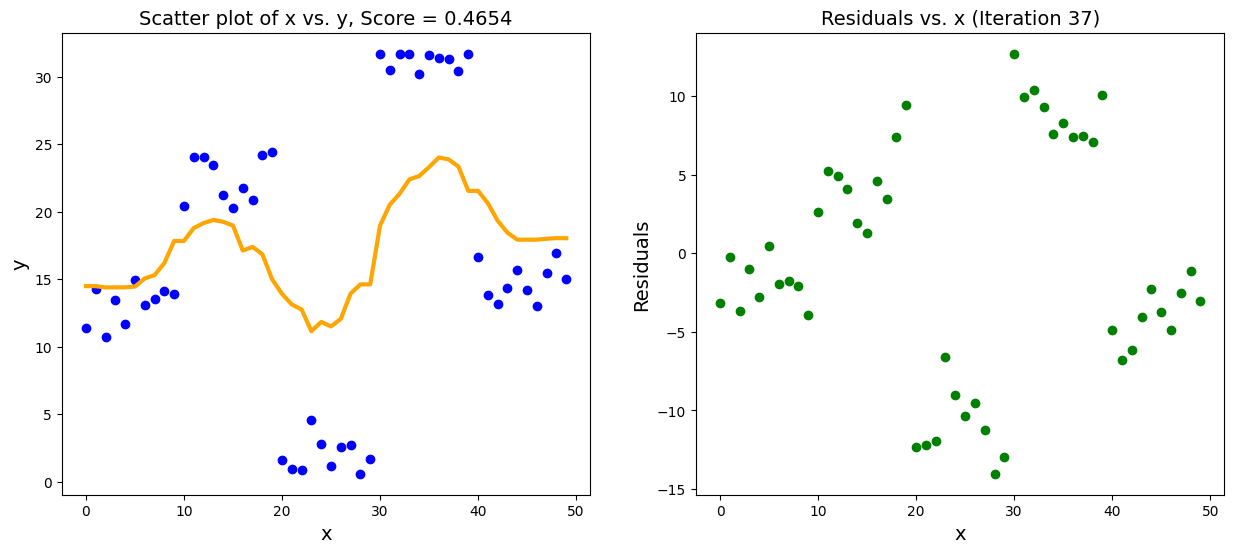

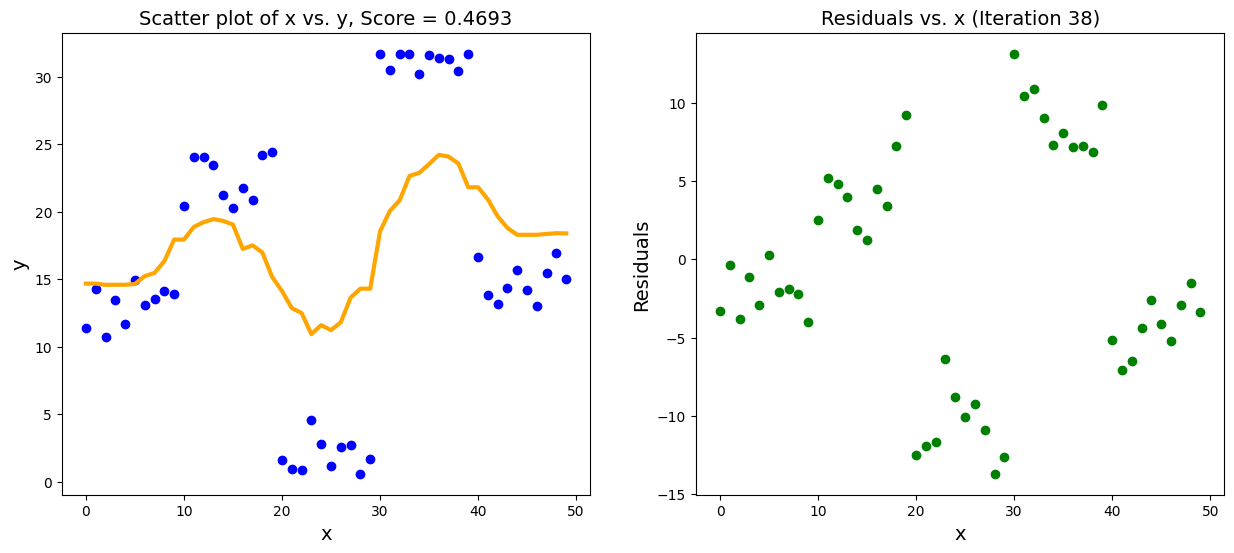

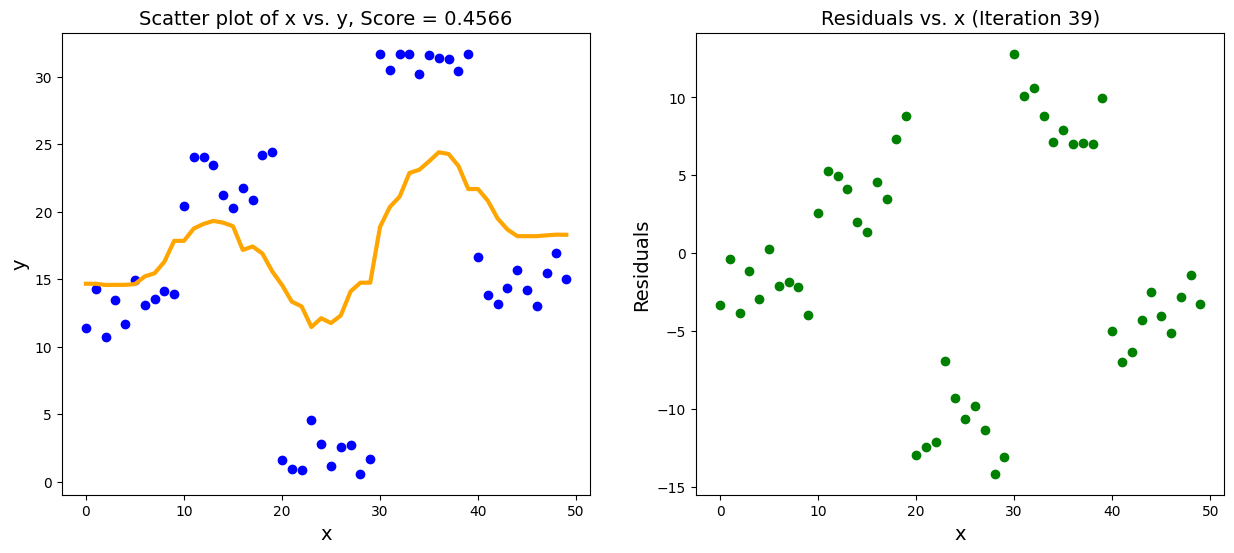

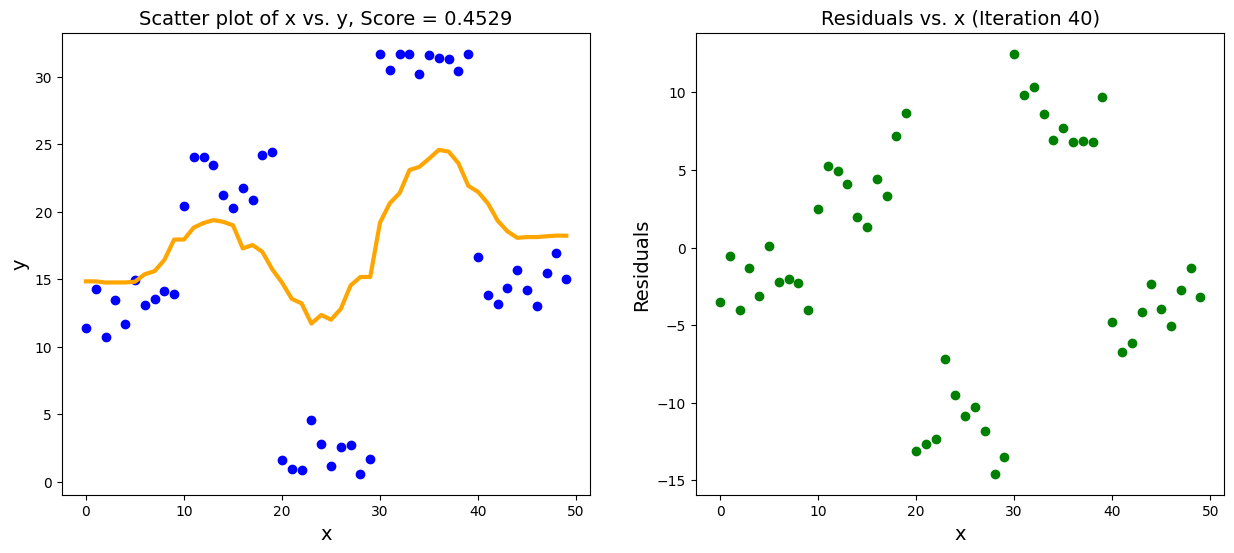

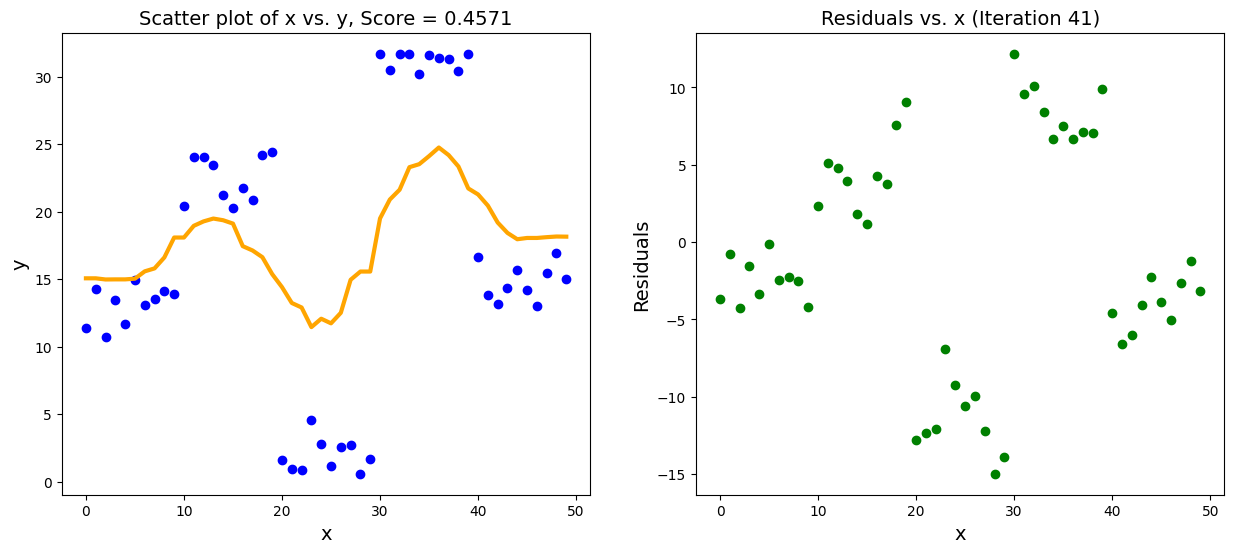

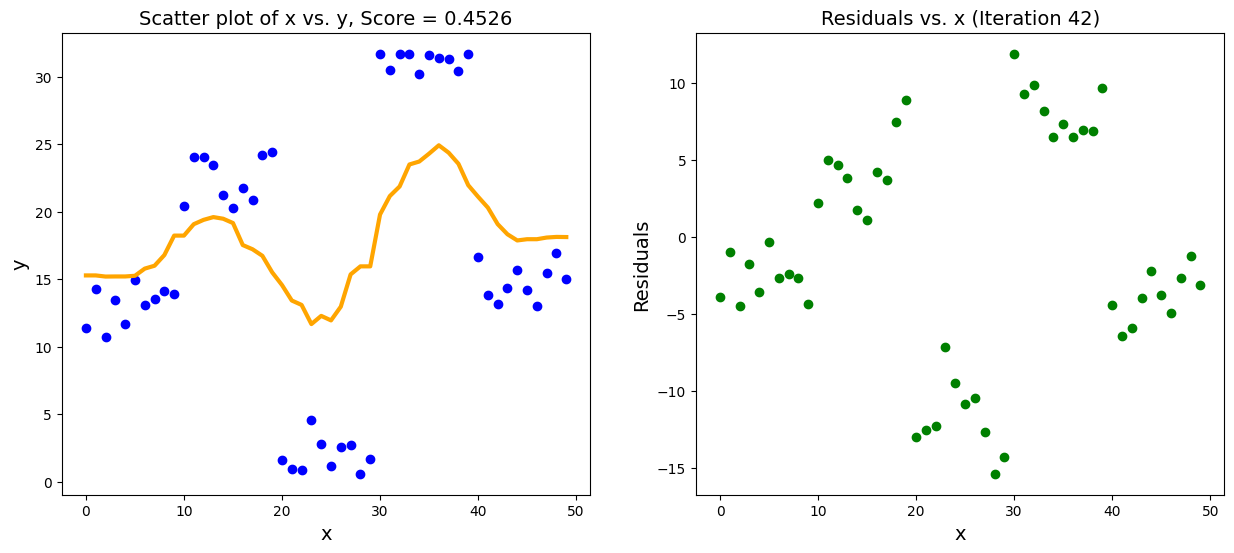

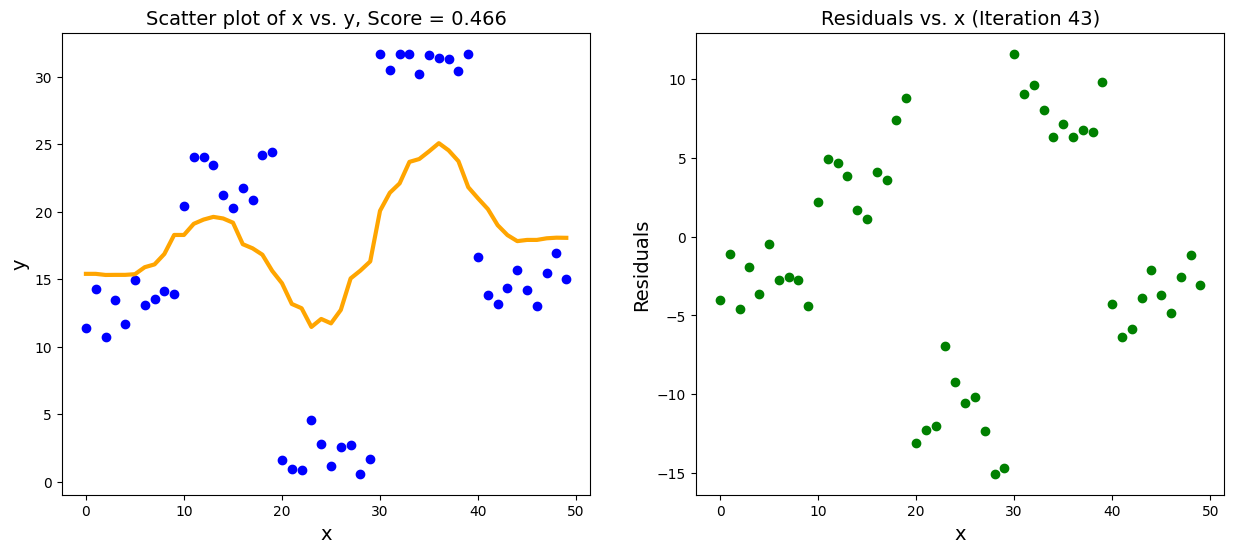

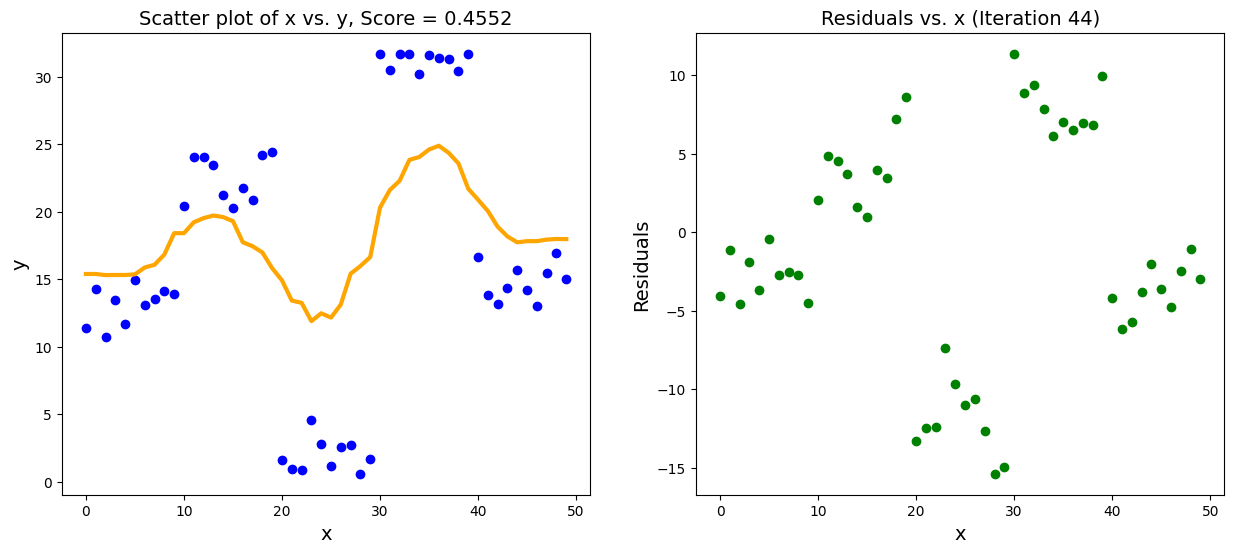

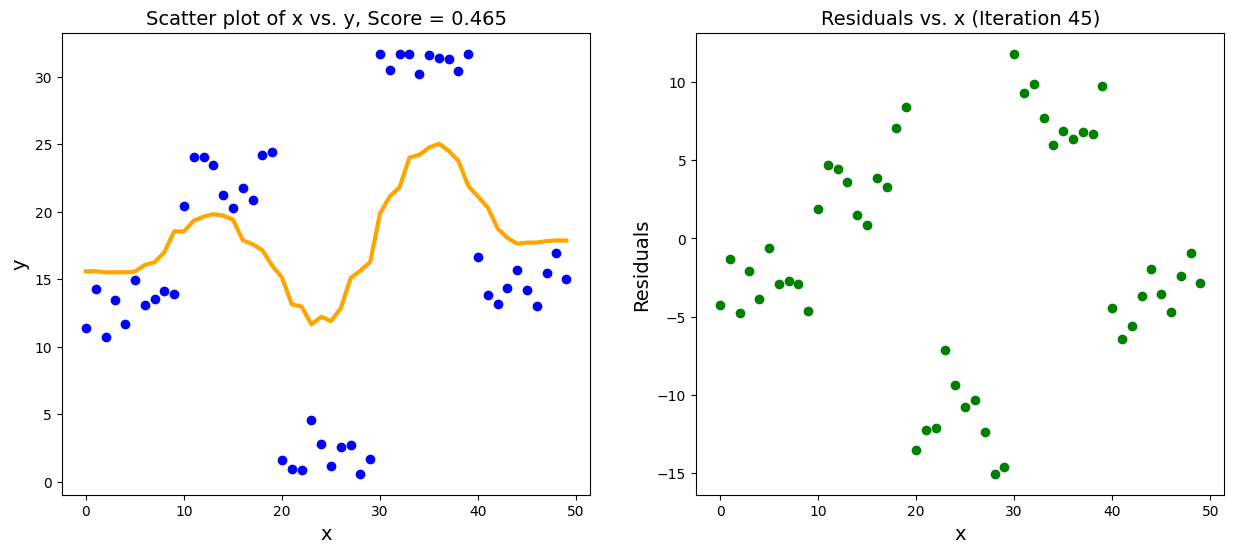

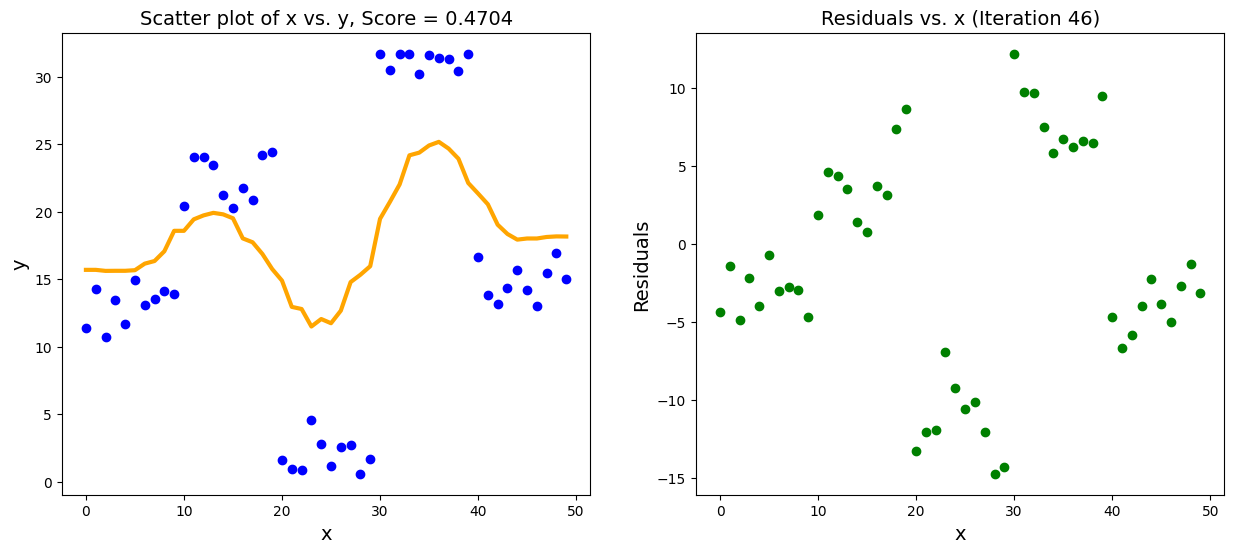

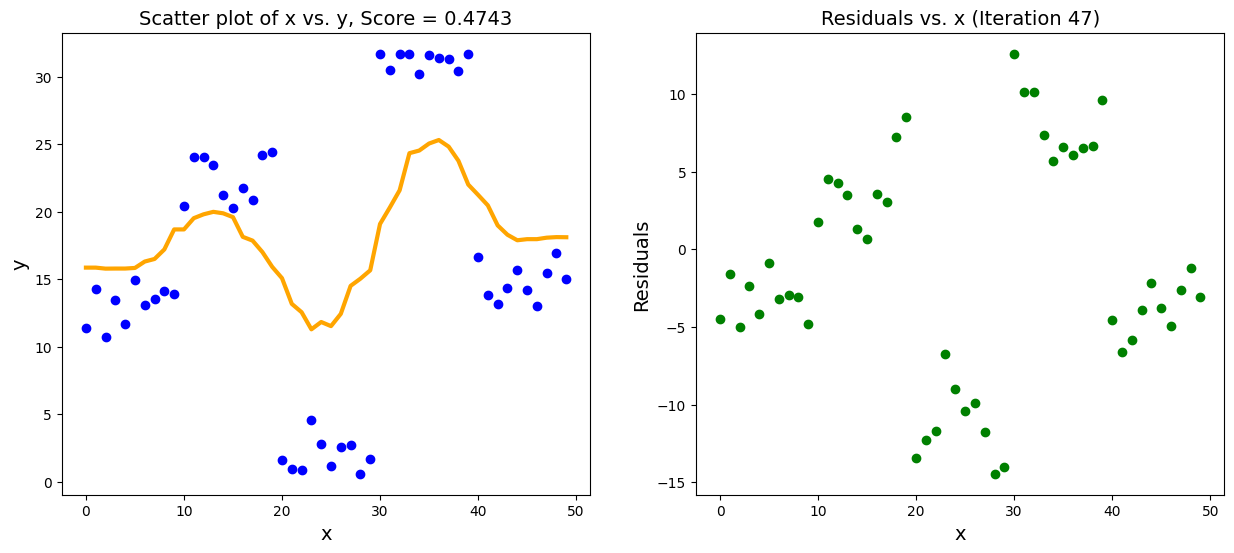

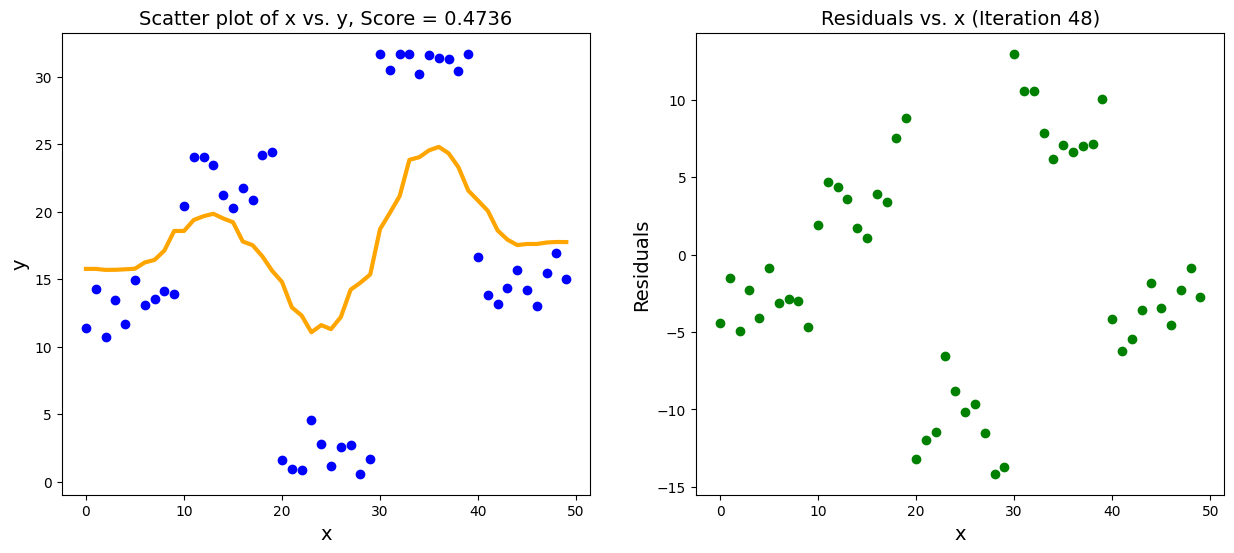

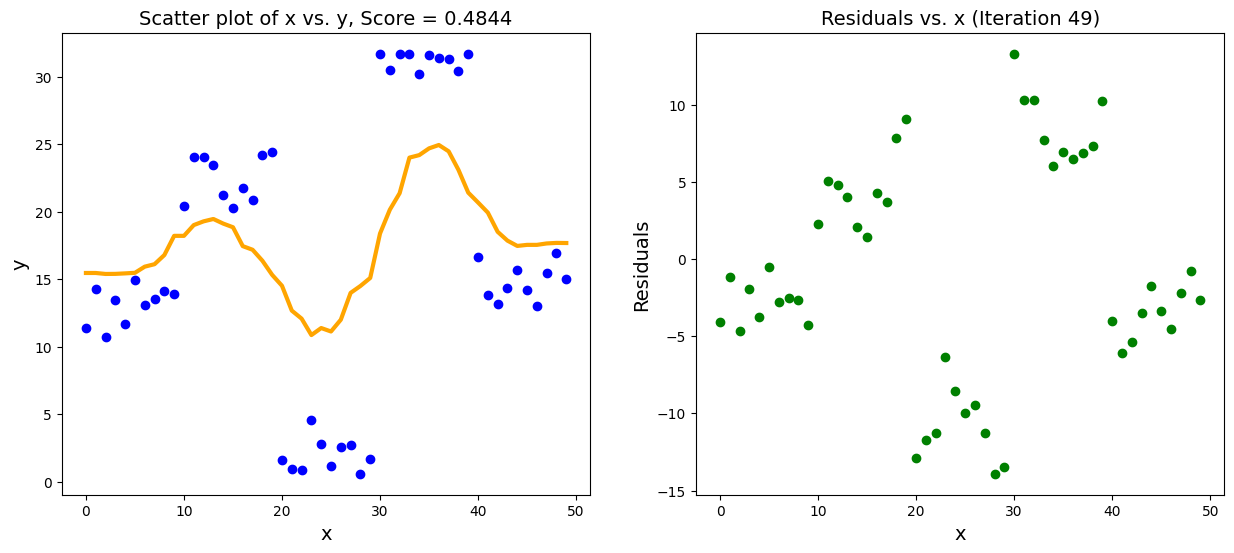

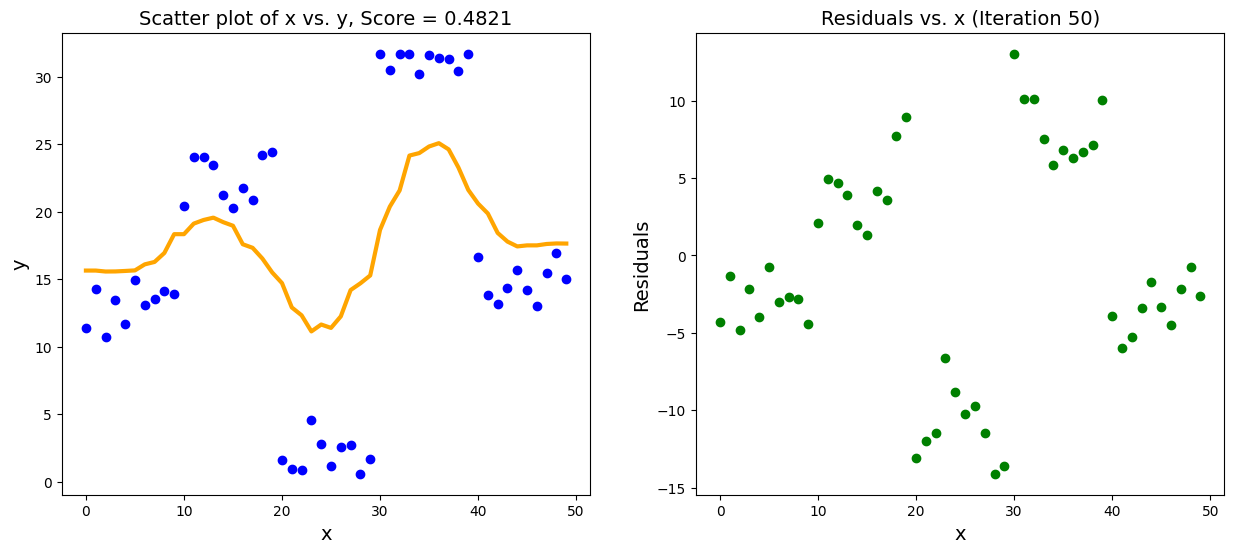

In [18]:
trees = []

for i in range(50):
    # в каждой итерации будем использовать только бутстреп-выборку из 10% объектов с возвратом
    idx = np.random.randint(0, len(x), size=len(x) // 10)
    
    # базовый алгоритм достаточно сложный: дерево с глубиной 5
    tree = DecisionTreeRegressor(max_depth=5, random_state=27)
    tree.fit(x.loc[idx], y[idx])

    trees.append(tree)
    y_pred = 0

    # в качестве результата берём среднее по всем алгоритмам
    for tree in trees:
        y_pred += tree.predict(x).reshape((50, 1))
    y_pred = y_pred / len(trees)

    # остатки - чисто для визуализации
    residuals = y - y_pred
    
    score = r2_score(
        y, y_pred
    )

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(x, y, "o", color="blue")
    plt.plot(x, y_pred, color="orange", linewidth=3)
    plt.title(f"Scatter plot of x vs. y, Score = {round(score, 4)}", size=14)
    plt.xlabel("x", size=14)
    plt.ylabel("y", size=14)

    plt.subplot(122)
    plt.plot(x, residuals, "o", color="green")
    plt.title(f"Residuals vs. x (Iteration {i+1})", size=14)
    plt.ylabel("Residuals", size=14)
    plt.xlabel("x", size=14)
    plt.show()

Обратите внимание, что после нескольких итераций качество предсказания перестаёт улучшаться, т.е. бэггинг оказался неспособен учесть всю сложность зависимости при небольшом количестве данных

## Загрузка данных

In [6]:
data = pd.read_csv("train.csv")
data.head(n=2)

ID_code  target    var_0   var_1    var_2  var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.093  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.389  12.3622  7.0433  5.6208   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  

[2 rows x 202 columns]

In [7]:
x_train, x_valid = train_test_split(
    data.drop(["ID_code", "target"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    data["target"], train_size=0.7, random_state=1
)

## 1. Обучение базовой модели XGBoost (sklearn-API)

`XGBoost` поддерживает как свое собственное API, так и `sklearn-API`.

In [8]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=27, ...)

In [9]:
y_pred = baseline.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

score = 0.8239


## 2. Обучение модели XGBoost с использование оригинального API

In [19]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "nthread": 6,
    "gamma": 10,
    "seed": 27
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [20]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=25,
    
)

[0]	train-auc:0.61117	valid-auc:0.58390
[25]	train-auc:0.79940	valid-auc:0.73511
[50]	train-auc:0.85114	valid-auc:0.77891
[75]	train-auc:0.87601	valid-auc:0.80117
[100]	train-auc:0.89171	valid-auc:0.81559
[125]	train-auc:0.90306	valid-auc:0.82628
[150]	train-auc:0.91177	valid-auc:0.83431
[175]	train-auc:0.91809	valid-auc:0.84054
[200]	train-auc:0.92331	valid-auc:0.84548
[225]	train-auc:0.92800	valid-auc:0.84909
[250]	train-auc:0.93167	valid-auc:0.85259
[275]	train-auc:0.93514	valid-auc:0.85471
[300]	train-auc:0.93800	valid-auc:0.85712
[325]	train-auc:0.94041	valid-auc:0.85908
[350]	train-auc:0.94101	valid-auc:0.86023
[375]	train-auc:0.94115	valid-auc:0.86038
[400]	train-auc:0.94115	valid-auc:0.86038
[425]	train-auc:0.94115	valid-auc:0.86038


Text(0, 0.5, 'ROC-AUC')

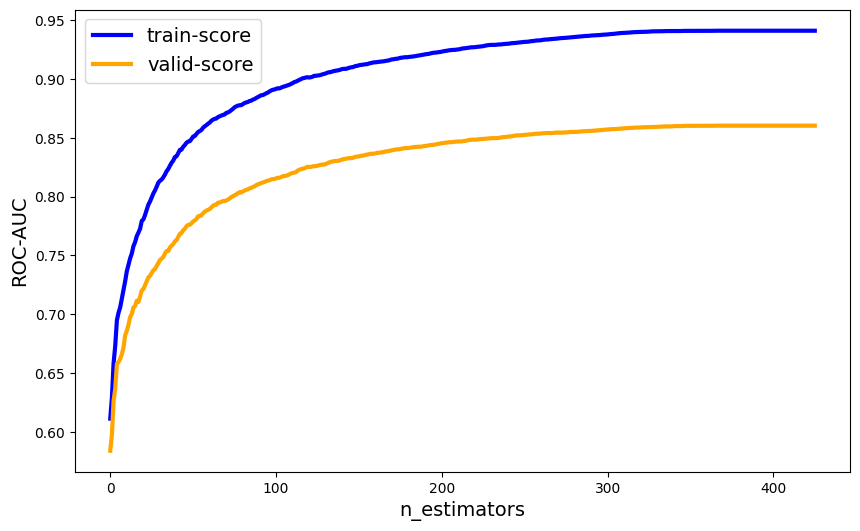

In [21]:
fig = plt.figure(figsize=(10, 6))
plt.plot(evals_result["train"]["auc"], linewidth=3, label="train-score", color="blue")
plt.plot(evals_result["valid"]["auc"], linewidth=3, label="valid-score", color="orange")
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

In [22]:
cv_score = xgb.cv(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=25,
    maximize=True,
    nfold=3,
)

[0]	train-auc:0.62072+0.00354	test-auc:0.60216+0.00165
[25]	train-auc:0.80588+0.00843	test-auc:0.75132+0.00288
[50]	train-auc:0.85646+0.00549	test-auc:0.78744+0.00349
[75]	train-auc:0.88259+0.00507	test-auc:0.80814+0.00470
[100]	train-auc:0.89877+0.00431	test-auc:0.82038+0.00525
[125]	train-auc:0.91085+0.00459	test-auc:0.82954+0.00524
[150]	train-auc:0.91904+0.00440	test-auc:0.83728+0.00565
[175]	train-auc:0.92603+0.00370	test-auc:0.84289+0.00595
[200]	train-auc:0.93117+0.00368	test-auc:0.84752+0.00627
[225]	train-auc:0.93541+0.00340	test-auc:0.85090+0.00715
[250]	train-auc:0.93862+0.00366	test-auc:0.85421+0.00729
[275]	train-auc:0.93959+0.00366	test-auc:0.85527+0.00758
[300]	train-auc:0.93988+0.00366	test-auc:0.85563+0.00742
[325]	train-auc:0.93990+0.00369	test-auc:0.85573+0.00728
[350]	train-auc:0.93990+0.00369	test-auc:0.85573+0.00728
[366]	train-auc:0.93990+0.00369	test-auc:0.85573+0.00728


Text(0, 0.5, 'ROC-AUC')

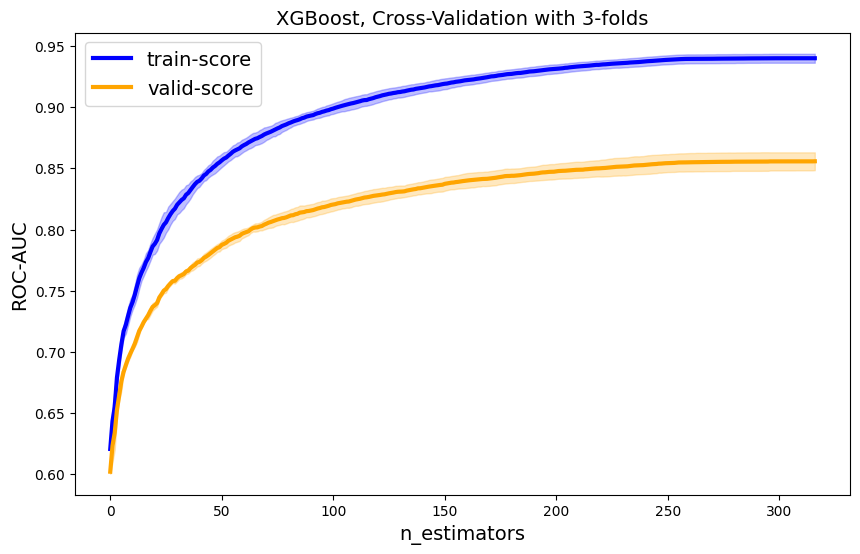

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.title("XGBoost, Cross-Validation with 3-folds", size=14)
plt.plot(
    cv_score["train-auc-mean"],
    label="train-score",
    linewidth=3,
    color="blue"
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["train-auc-mean"]-cv_score["train-auc-std"],
    y2=cv_score["train-auc-mean"]+cv_score["train-auc-std"],
    color="blue", alpha=0.25
)
plt.plot(
    cv_score["test-auc-mean"],
    label="valid-score",
    color="orange",
    linewidth=3
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["test-auc-mean"]-cv_score["test-auc-std"],
    y2=cv_score["test-auc-mean"]+cv_score["test-auc-std"],
    color="orange", alpha=0.25
)
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

## 3. Интерпретация работы модели XGBoost

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

## 3.1. Интерпретация поведения модели на одном объекте

In [25]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:], x_valid.iloc[0,:],
    link="logit"
)

## 3.2. Пути принятия решений моделью на совокупности объектов

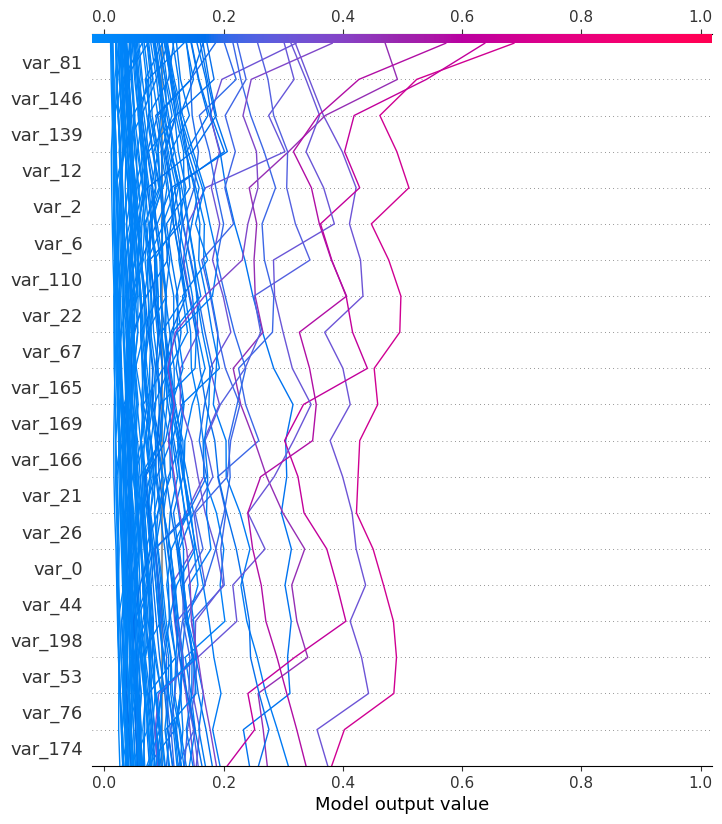

In [26]:
idx = np.random.randint(
    0, x_valid.shape[0], 100
)

shap.decision_plot(
    explainer.expected_value,
    shap_values[idx, :],
    x_valid.iloc[idx,:],
    link="logit")

## 3.3. Важность признаков для модели

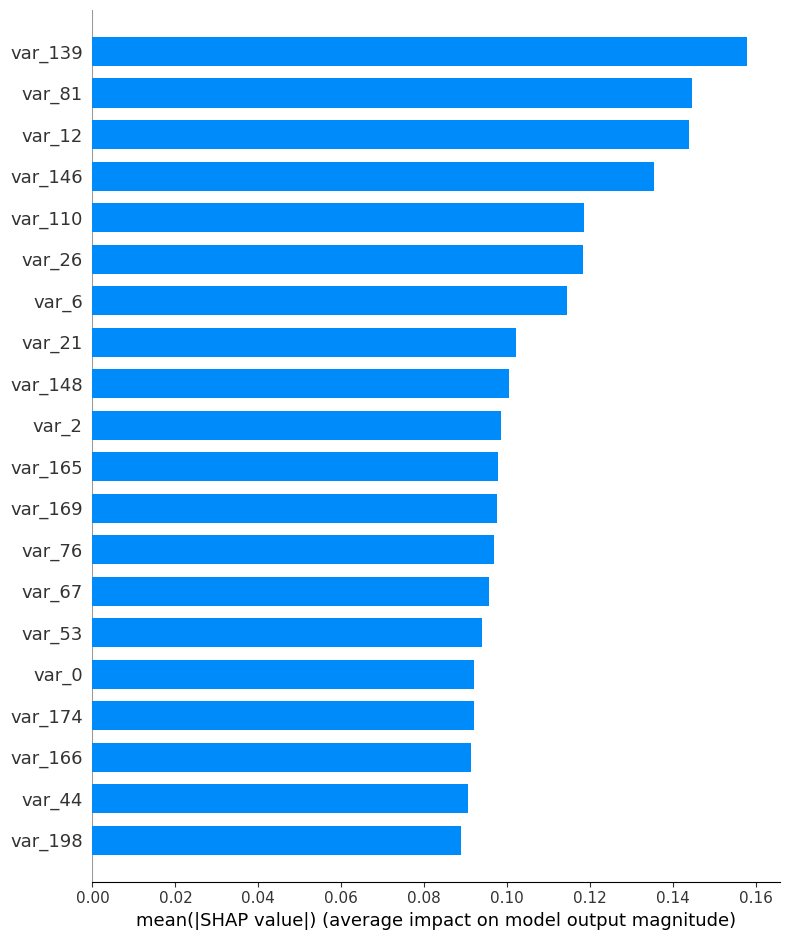

In [27]:
shap.summary_plot(
    shap_values, x_valid, plot_type="bar", max_display=20
)

## 3.4. Взаимодействие признаков между собой

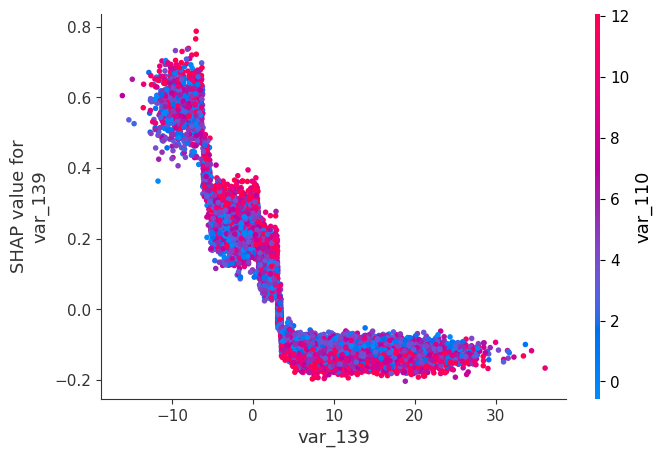

In [28]:
shap.dependence_plot("var_139", shap_values, x_valid)

## 3.5. Суммарный эффект для всех признаков

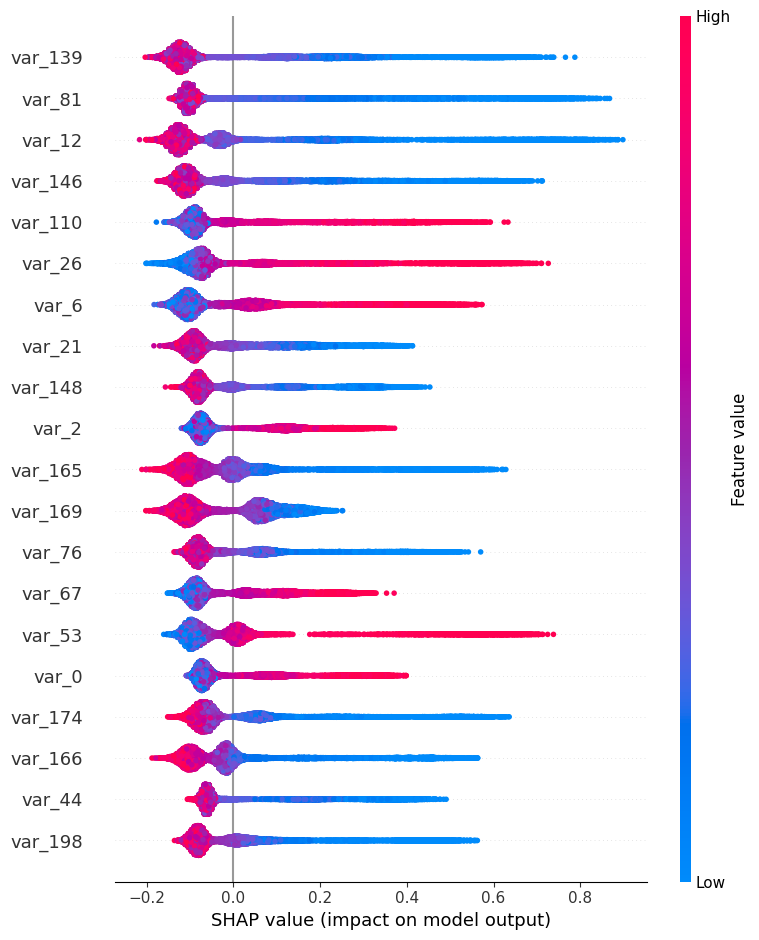

In [29]:
shap.summary_plot(shap_values, x_valid)

## 4. Обучение базовой модели CatBoost (sklearn-API)

`CatBoost` поддерживает как свое собственное `API`, так и `sklearn-API`.

In [30]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(x_train, y_train)

Learning rate set to 0.050823
0:	learn: 0.6493747	total: 222ms	remaining: 3m 41s
1:	learn: 0.6110161	total: 274ms	remaining: 2m 16s
2:	learn: 0.5771441	total: 325ms	remaining: 1m 48s
3:	learn: 0.5469270	total: 388ms	remaining: 1m 36s
4:	learn: 0.5202961	total: 446ms	remaining: 1m 28s
5:	learn: 0.4967743	total: 499ms	remaining: 1m 22s
6:	learn: 0.4755537	total: 553ms	remaining: 1m 18s
7:	learn: 0.4570216	total: 605ms	remaining: 1m 15s
8:	learn: 0.4408103	total: 661ms	remaining: 1m 12s
9:	learn: 0.4261178	total: 732ms	remaining: 1m 12s
10:	learn: 0.4135912	total: 807ms	remaining: 1m 12s
11:	learn: 0.4027118	total: 894ms	remaining: 1m 13s
12:	learn: 0.3924793	total: 982ms	remaining: 1m 14s
13:	learn: 0.3837103	total: 1.07s	remaining: 1m 15s
14:	learn: 0.3762103	total: 1.16s	remaining: 1m 15s
15:	learn: 0.3689805	total: 1.21s	remaining: 1m 14s
16:	learn: 0.3626765	total: 1.26s	remaining: 1m 13s
17:	learn: 0.3565416	total: 1.32s	remaining: 1m 12s
18:	learn: 0.3513020	total: 1.38s	remaining:

In [31]:
y_pred = model.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

score = 0.8747


## 5. Обучение модели CatBoost с использование оригинального API

In [32]:
cb_params = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cb_train = cb.Pool(
    data=x_train, label=y_train, cat_features=None
)
cb_valid = cb.Pool(
    data=x_valid, label=y_valid, cat_features=None
)

In [33]:
model = cb.train(
    params=cb_params,
    dtrain=cb_train,
    eval_set=[cb_train, cb_valid],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5743413	test1: 0.5575319	best: 0.5575319 (0)	total: 58.2ms	remaining: 4m 50s
50:	test: 0.8342644	test1: 0.7539641	best: 0.7555973 (49)	total: 3.37s	remaining: 5m 26s
100:	test: 0.8286367	test1: 0.7679550	best: 0.7692494 (84)	total: 6.08s	remaining: 4m 54s
150:	test: 0.8219675	test1: 0.7712560	best: 0.7725185 (118)	total: 10.5s	remaining: 5m 35s
200:	test: 0.8246509	test1: 0.7784949	best: 0.7784949 (200)	total: 14.4s	remaining: 5m 42s
250:	test: 0.8305959	test1: 0.7845840	best: 0.7845840 (250)	total: 18s	remaining: 5m 40s
300:	test: 0.8341208	test1: 0.7895367	best: 0.7896780 (299)	total: 21.5s	remaining: 5m 35s
350:	test: 0.8393831	test1: 0.7950170	best: 0.7950270 (349)	total: 24.9s	remaining: 5m 30s
400:	test: 0.8454068	test1: 0.8006840	best: 0.8006923 (399)	total: 28.3s	remaining: 5m 24s
450:	test: 0.8500478	test1: 0.8055809	best: 0.8055809 (450)	total: 31.8s	remaining: 5m 20s
500:	test: 0.8553930	test1: 0.8109984	best: 0.8109984 (500)	total: 35.6s	remaining: 5m 19s
550:	te

In [34]:
catboost_cv = cb.cv(
    pool=cb_train,
    params=cb_params,
    plot=True,
    nfold=3,
    seed=27
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	test: 0.5486083	best: 0.5486083 (0)	total: 53.1ms	remaining: 4m 25s
50:	test: 0.7689651	best: 0.7689651 (50)	total: 2.99s	remaining: 4m 50s
100:	test: 0.7799982	best: 0.7885056 (83)	total: 5.8s	remaining: 4m 41s

bestTest = 0.7885055638
bestIteration = 83

Training on fold [1/3]
0:	test: 0.5544967	best: 0.5544967 (0)	total: 59.3ms	remaining: 4m 56s
50:	test: 0.7613390	best: 0.7620742 (48)	total: 2.97s	remaining: 4m 48s
100:	test: 0.7851725	best: 0.7894002 (84)	total: 5.79s	remaining: 4m 40s
150:	test: 0.7886259	best: 0.7899036 (121)	total: 8.57s	remaining: 4m 35s

bestTest = 0.7899036461
bestIteration = 121

Training on fold [2/3]
0:	test: 0.5633395	best: 0.5633395 (0)	total: 65.9ms	remaining: 5m 29s
50:	test: 0.7630491	best: 0.7630491 (50)	total: 2.88s	remaining: 4m 39s
100:	test: 0.7962266	best: 0.7976567 (98)	total: 5.68s	remaining: 4m 35s
150:	test: 0.7926337	best: 0.7985812 (104)	total: 8.53s	remaining: 4m 33s

bestTest = 0.7985812076
bestIteration = 104


In [3]:
df = pd.read_csv('data.csv')
df.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    df[['TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']],
    df['isFraud'],
    train_size=0.70,
    shuffle=True,
    random_state=1
)

In [10]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

Learning rate set to 0.063211
0:	learn: 0.5862561	total: 352ms	remaining: 5m 51s
1:	learn: 0.4966476	total: 377ms	remaining: 3m 8s
2:	learn: 0.4241390	total: 399ms	remaining: 2m 12s
3:	learn: 0.3657505	total: 432ms	remaining: 1m 47s
4:	learn: 0.3201338	total: 461ms	remaining: 1m 31s
5:	learn: 0.2822190	total: 487ms	remaining: 1m 20s
6:	learn: 0.2538220	total: 508ms	remaining: 1m 12s
7:	learn: 0.2285392	total: 526ms	remaining: 1m 5s
8:	learn: 0.2058343	total: 544ms	remaining: 59.9s
9:	learn: 0.1871970	total: 564ms	remaining: 55.8s
10:	learn: 0.1725764	total: 587ms	remaining: 52.8s
11:	learn: 0.1598040	total: 618ms	remaining: 50.9s
12:	learn: 0.1498144	total: 640ms	remaining: 48.6s
13:	learn: 0.1413867	total: 661ms	remaining: 46.5s
14:	learn: 0.1347761	total: 678ms	remaining: 44.5s
15:	learn: 0.1282776	total: 695ms	remaining: 42.7s
16:	learn: 0.1226936	total: 711ms	remaining: 41.1s
17:	learn: 0.1192719	total: 728ms	remaining: 39.7s
18:	learn: 0.1161439	total: 754ms	remaining: 39s
19:	lea

In [11]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(X_train, y_train)

y_pred = baseline.predict_proba(X_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

C:\Users\URIST\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


score = 0.8621


C:\Users\URIST\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


[0]	train-auc:0.803504	valid-auc:0.796418


C:\Users\URIST\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
C:\Users\URIST\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	train-auc:0.891902	valid-auc:0.862791
[50]	train-auc:0.923663	valid-auc:0.886689
[75]	train-auc:0.933052	valid-auc:0.892101
[100]	train-auc:0.933052	valid-auc:0.892101
Stopping. Best iteration:
[72]	train-auc:0.933052	valid-auc:0.892101



Text(0, 0.5, 'ROC-AUC')

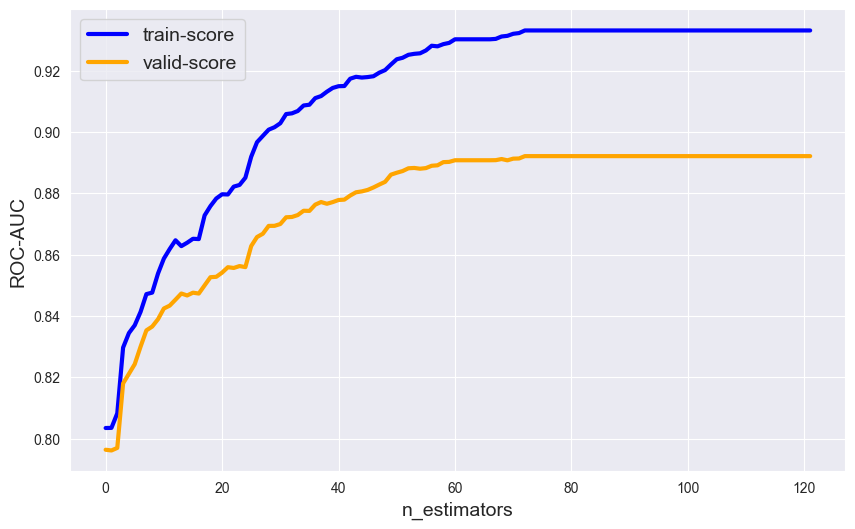

In [21]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 1,
    "max_depth": 10,
    "nthread": 6,
    "gamma": 10,
    "seed": 27
}

dtrain = xgb.DMatrix(
    data=X_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=X_valid, label=y_valid
)


evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=25,
    
)

fig = plt.figure(figsize=(10, 6))
plt.plot(evals_result["train"]["auc"], linewidth=3, label="train-score", color="blue")
plt.plot(evals_result["valid"]["auc"], linewidth=3, label="valid-score", color="orange")
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)